# DIA Analysis: Source, Object, and Postage Stamps for Run 1.2p Test
Michael Wood-Vasey
Last Verified to Run: 2019-07-06

After completing this Notebook, the users will be able to
1. Plot statistics of DIAObject and DIASource tables.
2. Select and plot lightcurve of DIA Object.
3. Locate that DIA Object in the truth catalog of input variables
4. Describe how DIASource and DIAObject tables are constructed.
5. Display and inspect postage stamps of a selected DIAObject.

## Introduction and Key Concepts

LSST Science Pipeline code includes the ability to compare images for new or variable sources.  LSST DESC uses a package called `dia_pipe` to execute this image subtraction and analysis code.  
In the vocabulary of LSST these are called Difference Image Analysis (DIA) products.
* Detections on a subtracted image are called "DIA Sources"
* DIA Sources are spatially associated across subtracted images into "DIA Objects".
* The above two data products are made available in the `DIASource` and `DIAObject` tables.  These tables follow the definitions in the [LSST Data Products Definition Document](https://ls.st/dpdd)
* `DIASource` and `DIAObject` tables for Run 1.2p are available through the GCR interface.  
* The processing data repository (`repo` below) is where the processing was done.  Using the collated `DIASource` and `DIAObject` tables is much more convenient to use then loading up each of the individual files from the processing repo each time, we *will* need to use the data repository to access the image pixels.

In [1]:
# Inject gcr-catalogs that supports DIA source into path.
import os
import math
import sys

import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
from lsst.daf.persistence import Butler
from lsst.geom import SpherePoint
import lsst.geom

In [3]:
import GCRCatalogs

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

In [5]:
# The DIA analysis is still in test phase.   The current test repo, based on Run 1.2p, is here:
repo = '/global/cscratch1/sd/rearmstr/new_templates/diffim_template'

In [6]:
diaSrc = GCRCatalogs.load_catalog('dc2_dia_source_run1.2p_test')
diaObject = GCRCatalogs.load_catalog('dc2_dia_object_run1.2p_test')

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/GCR/base.py:373: UserWarning: Native quantity `psFluxMean_{band}` does not exist (required by `magMeanErr_i`, `magMeanErr_z`, `magMeanErr_g`, `magMeanErr_y`, `magMeanErr_r`, `magMeanErr_u`)
  warnings.warn(msg)


(We presently will get a warning from the catalog reader in the initalization above because there is no u-band in the subtractions.)

Let's star with some simple questions:
1. How many DIA Sources are there?
2. What's the distribution in RA, Dec?
3. What's the mag vs. mag_err plot
4. Can we get out the filter information?

In [7]:
print(f'There are {len(diaSrc)} DIA Sources and {len(diaObject)} DIA Objects in this test sample')

There are 73220 DIA Sources and 18864 DIA Objects in this test sample


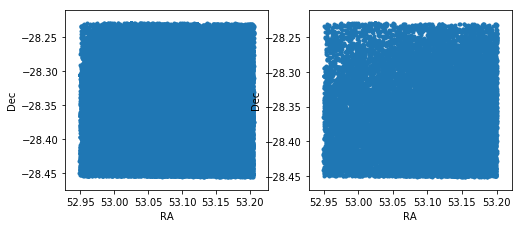

In [8]:
def scatter_radec(cat, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.scatter(cat['ra'], cat['dec'], marker='.')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    
    # While we're doing a rectangular plot of the local tangent, we can at least get the local scale right
    median_ra, median_dec = np.median(cat['ra']), np.median(cat['dec'])
    ax.set_aspect(aspect=abs(1/math.cos(median_dec)))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
scatter_radec(diaSrc, ax1)
scatter_radec(diaObject, ax2)

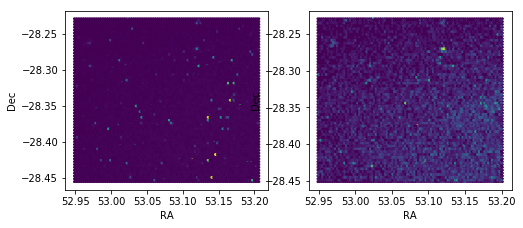

In [9]:
def hexbin_radec(cat, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.hexbin(cat['ra'], cat['dec'])
    # I don't know how to do colorbar from the axis
    #    ax.colorbar()
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')

    # While we're doing a rectangular plot of the local tangent, we can at least get the local scale right
    median_ra, median_dec = np.median(cat['ra']), np.median(cat['dec'])
    ax.set_aspect(aspect=abs(1/math.cos(median_dec)))
    
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
hexbin_radec(diaSrc, ax1)
hexbin_radec(diaObject, ax2)

In [10]:
diaSrc_r = diaSrc.get_quantities(['ra', 'dec', 'mag', 'mag_err', 'psFlux', 'psFluxErr'],
                           filters=[(lambda x: x == 'r', 'filter'), 'mag_err < 0.1'])

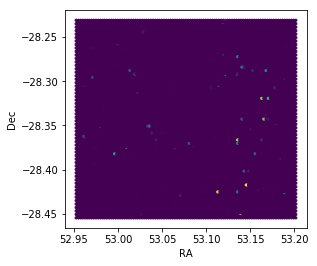

In [11]:
hexbin_radec(diaSrc_r)

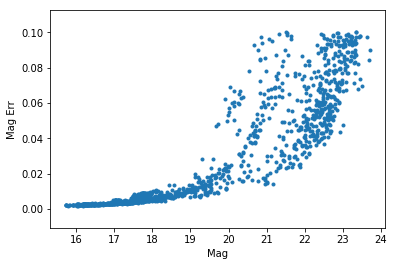

In [12]:
def scatter_mag(cat, ax=None):
    if ax is None:
        ax = plt.gca()
    mag, mag_err = cat['mag'], cat['mag_err']
    ax.scatter(mag, mag_err, marker='.')
    ax.set_xlabel('Mag')
    ax.set_ylabel('Mag Err')

scatter_mag(diaSrc_r)
# Oh, there is no mag yet for diaObject.
# scatter_mag(diaObject) 

In [13]:
cat_by_filter = {}
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
columns = ['ra', 'dec', 'mag', 'mag_err', 'psFlux', 'psFluxErr', 'visit']

for f in filter_names: 
    cat_by_filter[f] = diaSrc.get_quantities(columns,
                                          filters=[(lambda x: x == f, 'filter'), 'mag_err < 0.1'])

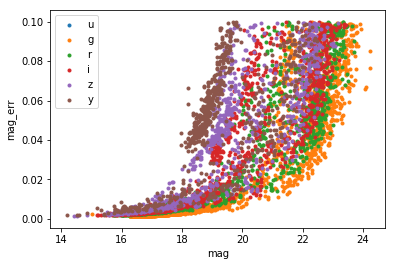

In [14]:
for f, this_cat in cat_by_filter.items():
    plt.scatter(this_cat['mag'], this_cat['mag_err'], marker='.', label=f)

plt.legend()
plt.xlabel('mag')
plt.ylabel('mag_err');

In [15]:
diaSrc.list_all_quantities()

['mjd',
 'visit',
 'apFlux_flag',
 'fluxmag0',
 'psNdata',
 'diaSourceId',
 'Ixx',
 'ixyPSF',
 'filter',
 'dipAngle',
 'totFluxErr',
 'apFlux',
 'diaObjectId',
 'psFlux_flag',
 'y',
 'mag',
 'detector',
 'psFlux',
 'IxxPSF',
 'Ixy',
 'dipChi2',
 'isDipole',
 'apFluxErr',
 'xy_flag',
 'magerr',
 'ra',
 'I_flag',
 'x',
 'xErr',
 'clean',
 'totFlux',
 'IyyPSF',
 'IxyPSF',
 'Iyy',
 'good',
 'psFluxErr',
 'yErr',
 'dec',
 'parentDiaSourceId']

In [16]:
diaObject.list_all_quantities()

['magMeanStd_r',
 'psFluxMean_g',
 'psFluxMean_r',
 'psFluxMeanErr_y',
 'magMeanErr_g',
 'magMeanErr_y',
 'psFluxChi2_i',
 'magMeanErr_i',
 'psFluxMean_i',
 'psFluxMeanErr_u',
 'psFluxMean_u',
 'magMean_u',
 'psFluxMeanErr_i',
 'psFluxSigma_r',
 'psFluxNdata_i',
 'psFluxChi2_y',
 'psFluxSigma_i',
 'magMean_g',
 'psFluxMean_y',
 'magMeanStd_y',
 'diaObjectId',
 'psFluxSigma_z',
 'psFluxMean_z',
 'magMean_y',
 'magMeanStd_z',
 'psFluxChi2_g',
 'psFluxSigma_y',
 'psFluxMeanErr_r',
 'psFluxNdata_g',
 'psFluxChi2_z',
 'magMeanErr_r',
 'psFluxSigma_g',
 'magMeanErr_z',
 'psFluxNdata_z',
 'psFluxSigma_u',
 'magMeanStd_i',
 'magMeanErr_u',
 'psFluxNdata_y',
 'psFluxChi2_u',
 'psFluxChi2_r',
 'psFluxNdata_u',
 'psFluxNdata_r',
 'ra',
 'magMean_z',
 'magMeanStd_g',
 'clean',
 'magMean_r',
 'magMeanStd_u',
 'magMean_i',
 'psFluxMeanErr_g',
 'good',
 'psFluxMeanErr_z',
 'dec']

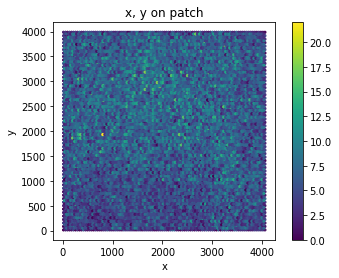

In [17]:
plt.hexbin(diaSrc['x'], diaSrc['y'])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect(aspect=1)
plt.title('x, y on patch');

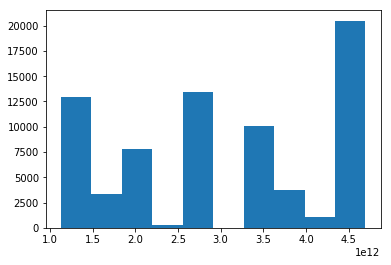

In [18]:
plt.hist(diaSrc['fluxmag0']);

## DIAObject statistics

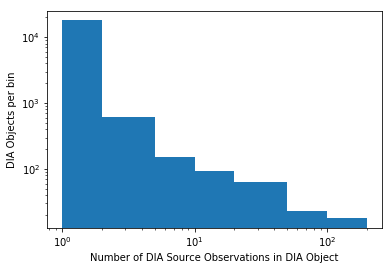

In [19]:
plt.hist(diaObject['nobs'], log=True, bins=[0, 1, 2, 5, 10, 20, 50, 100, 200])
plt.xlabel('Number of DIA Source Observations in DIA Object')
plt.ylabel('DIA Objects per bin');
plt.xscale('log')

In [20]:
reduced_chi2_r = diaObject['psFluxChi2_r']/(diaObject['psFluxNdata_r']-1)
log10_reduced_chi2_r = np.log10(reduced_chi2_r)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


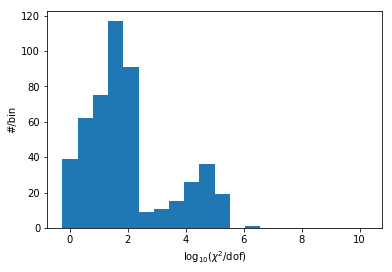

In [21]:
plt.hist(log10_reduced_chi2_r, range=(0, 10), bins=np.linspace(-0.25, 10.25, 21));
plt.xlabel(r'$\log_{10}(\chi^2/{\rm dof})$')
plt.ylabel('#/bin');

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:34: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


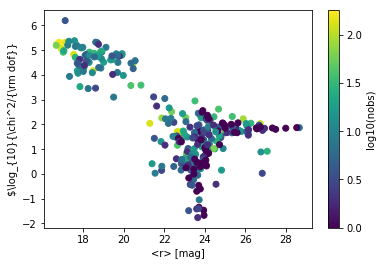

In [22]:
plt.scatter(diaObject['magMean_r'], log10_reduced_chi2_r,
           c=np.log10(diaObject['nobs']))

plt.xlabel('<r> [mag]')
plt.ylabel(r'$\log_{10}{\chi^2/{\rm dof}}')
plt.colorbar(label='log10(nobs)');

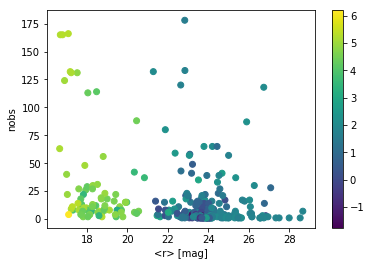

In [23]:
plt.scatter(diaObject['magMean_r'], diaObject['nobs'], c=log10_reduced_chi2_r)
plt.xlabel('<r> [mag]')
plt.ylabel('nobs')
plt.colorbar();

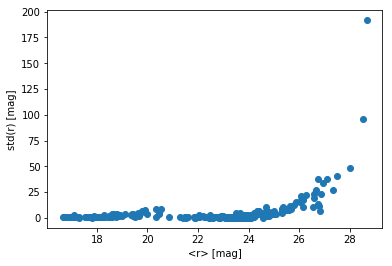

In [24]:
plt.scatter(diaObject['magMean_r'], diaObject['magMeanStd_r'])
plt.xlabel('<r> [mag]')
plt.ylabel('std(r) [mag]');

## A Lightcurve

Let's pick an object with lots of observations and $\chi^2/{\rm dof}$ significantly greater than one.

(Some of the `reduced_chi2` are non-positive, so we expect that we will get some "invalid value" warnings below when looking at the `log10_reduced_chi2` values.)

In [25]:
w, = np.where((diaObject['nobs'] > 100) & (log10_reduced_chi2_r > 2) & (log10_reduced_chi2_r < 3))
objectIds = (diaObject['diaObjectId'][w])

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [26]:
print(objectIds)

[21326977935867913 21326977935867980 21326977935870663]


In [27]:
this_diaObjectId = objectIds[0]
this_diaObject_diaSrc = pd.DataFrame(diaSrc.get_quantities(['ra', 'dec', 'diaObjectId', 'visit', 'detector', 'filter', 'mjd', 'mag', 'mag_err', 'psFlux', 'psFluxErr'], filters=[(lambda x: x == this_diaObjectId, 'diaObjectId')]))
this_diaObject = pd.DataFrame(diaObject.get_quantities(['ra', 'dec'], filters=[(lambda x: x == this_diaObjectId, 'diaObjectId')]))

In [28]:
this_diaObject_diaSrc

psFlux         ra           mjd    visit filter        diaObjectId  \
0     5156.712626  53.135775  61305.237275  1173534      i  21326977935867913   
1     5258.443232  53.135800  61308.369545  1176512      r  21326977935867913   
2     6124.110781  53.135795  61314.261014  1181556      r  21326977935867913   
3    13370.570724  53.135783  61314.276246  1181586      i  21326977935867913   
4     3098.092244  53.135794  61317.157823  1183930      r  21326977935867913   
5      141.584101  53.135818  61317.167198  1183949      g  21326977935867913   
6    11870.483405  53.135850  61333.159560  1196882      r  21326977935867913   
7     4838.906706  53.135791  61333.174792  1196912      i  21326977935867913   
8     8771.791719  53.135857  61336.194126  1198541      r  21326977935867913   
9     9502.562252  53.135770  61336.209358  1198571      i  21326977935867913   
10    8749.429702  53.135805  61336.219057  1198591      z  21326977935867913   
11   10647.834423  53.135832  61336.231256  1198617      y  21326977935867913   
12    8894.496881  53.135795  61344.118896  1203190      r  21326977935867913   
13     698.886219  53.135859  61344.143826  1203240      z  21326977935867913   
14    4783.362605  53.135817  61348.120940  1204004      r  21326977935867913   
15    1880.229397  53.135814  61348.130639  1204024      g  21326977935867913   
16    4843.866273  53.135829  61348.136172  1204034      i  21326977935867913   
17    8136.883825  53.135778  61348.158070  1204080      y  21326977935867913   
18    1446.705270  53.135819  61359.081209  1208179      r  21326977935867913   
19    -802.859084  53.135811  61370.055616  1215960      g  21326977935867913   
20    6911.492761  53.135797  61373.063310  1218145      i  21326977935867913   
21    6959.677182  53.135841  61376.050188  1220258      r  21326977935867913   
22    6650.220765  53.135867  61389.082396  1228669      z  21326977935867913   
23    7421.308769  53.135820  61392.084154  1230389      z  21326977935867913   
24    7917.853621  53.135755  61406.136096  1235276      r  21326977935867913   
25     479.680770  53.135867  61406.145795  1235296      g  21326977935867913   
26    6316.052636  53.135814  61406.151327  1235306      i  21326977935867913   
27    8130.480818  53.135820  61406.161026  1235326      z  21326977935867913   
28   12413.699539  53.135799  59598.135864    13320      z  21326977935867913   
29     967.725343  53.135820  61656.251401  1412295      g  21326977935867913   
..            ...        ...           ...      ...    ...                ...   
261   6850.908829  53.135813  61006.056436   969019      r  21326977935867913   
262   3361.840886  53.135782  61006.065719   969038      g  21326977935867913   
263   5746.567583  53.135808  61006.080950   969068      z  21326977935867913   
264   6862.114916  53.135794  61009.049396   970401      r  21326977935867913   
265   7826.574566  53.135790  61009.064627   970431      i  21326977935867913   
266   4148.961384  53.135828  61009.086525   970477      y  21326977935867913   
267   4808.729504  53.135852  61016.103165   975317      r  21326977935867913   
268   3928.028624  53.135810  61016.112864   975337      g  21326977935867913   
269   9046.748262  53.135783  61016.118397   975347      i  21326977935867913   
270   3033.498111  53.135876  61016.142581   975367      z  21326977935867913   
271   5242.434285  53.135775  61019.102064   976702      r  21326977935867913   
272  12672.413845  53.135747  61019.153914   976778      y  21326977935867913   
273   6297.433416  53.135753  61022.133623   978789      i  21326977935867913   
274   6930.786111  53.135881  61022.155521   978835      y  21326977935867913   
275   6691.495728  53.135812  61036.062943   988529      r  21326977935867913   
276   6726.409799  53.135740  61039.092794   990656      i  21326977935867913   
277   6169.432870  53.135832  61039.102493   990676      z  21326977935867913   
278  11253.759143  53.135837  61044.080240

In [29]:
def plot_lightcurve(df, plot='mag', title=None, marker='o', linestyle='none', **kwargs):
    """Plot a lightcurve from a DataFrame.
    """
    # At lexigraphical order, if not wavelength order.
    filters = np.unique(df['filter'])

    if plot == 'flux':
        flux_col = 'psFlux'
        flux_err_col = 'psFluxErr'
    else:
        flux_col = 'mag'
        flux_err_col = 'mag_err'
        
    for filt in filters:
        this_filter = df.query(f'filter == "{filt}"')
        # This if sequence is a little silly.
        if flux_err_col in this_filter.columns:
            plt.errorbar(this_filter['mjd'], this_filter[flux_col], this_filter[flux_err_col],
                         linestyle=linestyle, marker=marker,
                         label=filt, **kwargs)
        else:
            if marker is None:
                plt.plot(this_filter['mjd'], this_filter[flux_col],
                         linestyle=linestyle, marker=marker,
                         label=filt, **kwargs) 
            else:
                plt.scatter(this_filter['mjd'], this_filter[flux_col],
                            linestyle=linestyle, marker=marker,
                            label=filt, **kwargs)

    plt.xlabel('MJD')

    if plot == 'flux':
        plt.ylabel('psFlux [nJy]')
    else:
        plt.ylim(sorted(plt.ylim(), reverse=True))
        plt.ylabel('mag [AB]')

    if title is not None:
        plt.title(title)
    plt.legend()

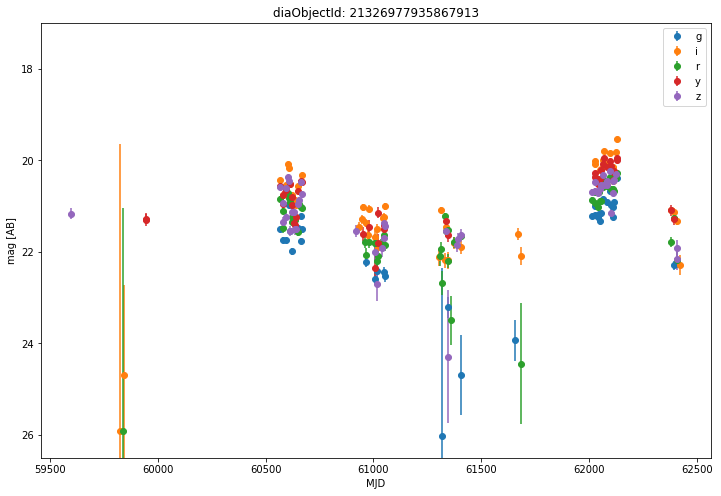

In [30]:
plt.figure(figsize=(12, 8))
plot_lightcurve(this_diaObject_diaSrc, title=f'diaObjectId: {this_diaObject_diaSrc["diaObjectId"][0]}')
plt.ylim(26.5, 17);

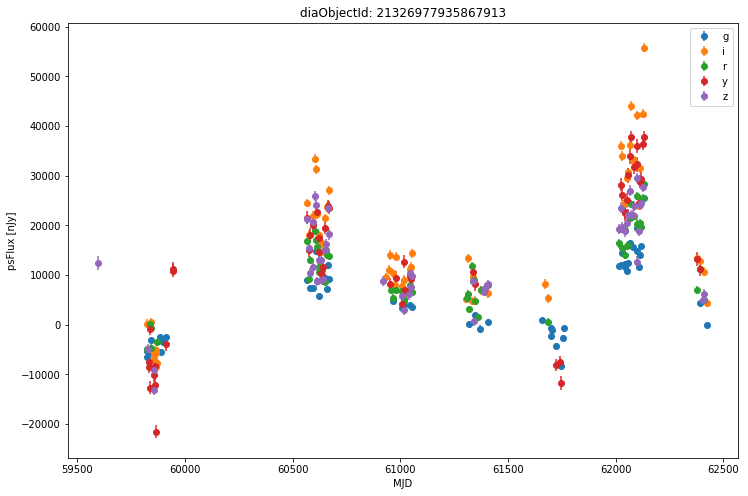

In [31]:
plt.figure(figsize=(12, 8))
plot_lightcurve(this_diaObject_diaSrc, plot='flux', title=f'diaObjectId: {this_diaObject_diaSrc["diaObjectId"][0]}')

### Match to Truth Catalog

This variable AGN presumably came from a variable source in the simulations.  Let's see if we can find it.  For more details on matching to the Truth Variable catalog, see
the [GCR Truth for Variables Tutorial](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/truth_gcr_variables.ipynb)

In [32]:
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_summary')
truth_cat.list_all_quantities(include_native=True)

['agn', 'ra', 'galaxy_id', 'sprinkled', 'sn', 'dec', 'redshift', 'uniqueId']

In [33]:
ra, dec = this_diaObject['ra'][0], this_diaObject['dec'][0]
print(ra, dec)

53.13580091149905 -28.426164731349527


In [34]:
truth_positions = SkyCoord(truth_cat['ra'], truth_cat['dec'], unit='deg')

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [35]:
from astropy.coordinates import SkyCoord

In [36]:
# Match on RA, Dec
from astropy.coordinates import SkyCoord

ra, dec = this_diaObject['ra'][0], this_diaObject['dec'][0]
truth = truth_cat.get_quantities(['ra', 'dec', 'uniqueId'])

agn_position = SkyCoord(ra, dec, unit='deg')
truth_positions = SkyCoord(truth['ra'], truth['dec'], unit='deg')

idx, sep2d, _ = agn_position.match_to_catalog_sky(truth_positions)
matchId = truth['uniqueId'][idx]

print(f'The truth object {matchId} is {sep2d.to(u.arcsec)[0]:0.6f} away')

The truth object 5963893 is 0.006690 arcsec away


In [37]:
truth_match = truth_cat.get_quantities(['ra', 'dec', 'redshift', 'agn', 'uniqueId', 'sprinkled', 'galaxy_id', 'sn'],
                                       filters=[f'uniqueId == {matchId}'])

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Here's the match!  Yes, it's an AGN in the truth catalog ('agn'==1)!

In [38]:
print(truth_match)

{'agn': array([1]), 'ra': array([53.135799]), 'sprinkled': array([0]), 'galaxy_id': array([5824]), 'sn': array([0]), 'dec': array([-28.42616394]), 'redshift': array([0.08929276]), 'uniqueId': array([5963893])}


How did we do with the lightcurve?

In [39]:
lc = GCRCatalogs.load_catalog('dc2_truth_run1.2_variable_lightcurve')
lc.list_all_quantities(include_native=True)

['obshistid', 'mjd', 'mag', 'filter', 'uniqueId']

In [40]:
# Using `native_filters` for the truth lightcurve is critical to performance here
# If you use `native_filters` then it does a match for `uniqueId` in the summary table 
# and just searches the lightcurve table for that id.
# If you accidentally use `filters`, the GCR will search for all ids in the summary table
# and then repeatedly search the entire lightcurve table for each ID that also matches uniqueId
truth_lc = pd.DataFrame(lc.get_quantities(['mjd', 'mag', 'filter'],
                                          native_filters=[f'uniqueId == {matchId}']))

In [41]:
truth_lc.rename(columns={'filter': 'filter_code'}, inplace=True)

In [42]:
truth_lc = truth_lc.sort_values('mjd')

In [43]:
# Translate filter codes to filter names
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
truth_lc['filter'] = [filter_names[f] for f in truth_lc['filter_code']]

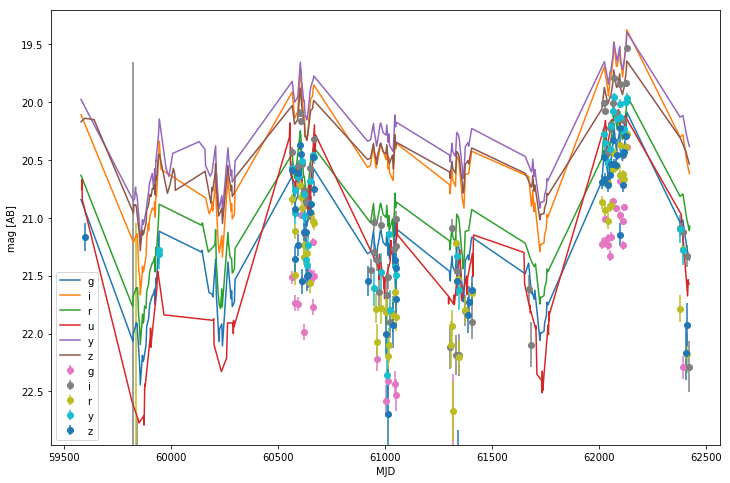

In [44]:
plt.figure(figsize=(12, 8))
plot_lightcurve(truth_lc, plot='mag', linestyle='-', marker=None)
plot_lightcurve(this_diaObject_diaSrc, plot='mag')

## Postage Stamp for DIA Object

For a fuller primer on making postage stamps, please see the
[DM Butler Postage Stamp Notebook](dm_butler_postage_stamps.ipynb)

But let's take a moment to discuss in more detail how the DIA products we're looking at were generated:

## How these data products were generated

These DIA products were generated using an existing set of Run 1.2p data that had been processed through the DM Science Pipelines.  Then `dia_pipe` was run to produce the image and individual catalog products, and code in `DC2-production` was wrun to collate these products and format them in a DPDD-like data product.

`dia_pipe`

* To run an image subtraction, one needs to identify a reference (or "Template") image.  The baseline model is that these Template images will be based on coadditions of images with the best seeing in a region.  In the DM processing these coadds are referred to as `datasetType='deepCoadd'`[1].

* For each Visit, the DIA processing subtracts the Template image from the Visit image.  This resulting image and associated information (calibration, PSF, masking) is stored by the DM Butler in `datasetType='deepDiff_differenceExp'`.

You will see each of these datasetTypes below when we make postage stamps.

The detections on each subtracted images are called `DIASource`s and measurements on the subtracted image are stored in `datasetType='deepDiff_diaSrc'`.

Once the subtractions are run on all the images, the `DIASource`s are spatially associated into `DIAObject`s.  Basic aggregrate quantities are calculated for the DIAObjects, but they're just a prototype placeholder.

Here ends the code in `dia_pipe`.

------

`DC2-production`

We then merged these `diaSrc` catalogs into a single `DIASource` table largely following the definitions laid out in the DPDD[2].  The associated catalogs were then merged into a `DIAObject` table.  Update aggregate quantities are then calculated per-filter for the `DIAObject` table.  These two tables are made available through the GCR interface.

The dividing line above will move downward as the `dia_pipe` develope and eventually gets merged into the main LSST code base.

Endnotes:
[1] The discussion in this Notebook includes some specific about the current test processing done by Bob Armstrong.  Details are likely to change.  In particular the choice of template process and name will likely change.  The processing here uses the `datasetType=='deepCoadd'` to refer to a good-seeing coadd, even though that same `datasetType` could refer to the full coadd in other processing.  By 2020 this nomenclature will evolve to hopefully a less confusing place.

[2] DPDD
If you're interested in the definition of a column, learning more about the data products, or just having trouble sleeping, I encourage you to spend some quality time with 

[The LSST Data Products Definition Document](https://ls.st/dpdd)

In [45]:
butler = Butler(repo)

In [46]:
def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    """
    Produce a cutout from datasetType from the given butler at the given RA, Dec in decimal degrees.
    
    Notes
    -----
    Trivial wrapper around 'cutout_coadd_spherepoint'
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
        
    Returns
    -------
    MaskedImage
    """
    radec = SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType)
    

def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
                       skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from datasetType at the given afw SpherePoint radec position.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    radec: lsst.afw.geom.SpherePoint 
        Coordinates of the center of the cutout.
    filter: string 
        Filter of the image to load
    datasetType: string ['deepCoadd']  
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional] 
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional] 
        Side of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage
    """
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("%s_skyMap" % datasetType)
    
    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filter}
    
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)

    return cutout_image

In [47]:
def cutout_visit_ra_dec(butler, ra, dec, dataId=None, datasetType='deepDiff_differenceExp', cutoutSideLength=75, **kwargs):
    """
    Produce a cutout from datasetType from the given butler at the given ra, dec
    
    Notes
    -----
    Trivial wrapper around 'cutout_spherepoint'
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    dataId: Butler data ID.  E.g., {'visit': 1181556, 'detector': 45, 'filter': 'r'}
    cutoutSideLength: float [optional] 
        Side of the cutout region in pixels.
         
    Returns
    -------
    MaskedImage
    """
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)
    radec = SpherePoint(ra, dec, afwGeom.degrees)
   
    image_wcs = butler.get(datasetType + '_wcs', dataId=dataId)
    xy = afwGeom.PointI(image_wcs.skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)
    
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, dataId=dataId)
    
    return cutout_image

In [48]:
def make_cutout_image(butler, ra, dec, dataId=None,
                      title=None,
                      frame=None, display=None, backend='matplotlib',
                      show=True, saveplot=False, savefits=False,
                      zscale=None,
                      datasetType='deepCoadd'):
    """
    Generate and optionally display and save a postage stamp for a given RA, Dec.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string 
        Filter of the image to load
    Returns
    -------
    MaskedImage

    Notes
    -----
    Uses lsst.afw.display with matplotlib to generate stamps.  Saves FITS file if requested.
    """
    
    if datasetType == 'deepCoadd':
        cutout_image = cutout_coadd_ra_dec(butler, ra, dec, dataId=dataId, datasetType=datasetType)
    else:
        cutout_image = cutout_visit_ra_dec(butler, ra, dec, dataId=dataId, datasetType=datasetType)

    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    radec = SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    if display is None:
        display = afwDisplay.Display(frame=frame, backend=backend)

    display.mtv(cutout_image)
    display.scale("linear", "zscale")
    display.dot('o', xy.getX(), xy.getY(), ctype='red')
    display.show_colorbar()

    plt.xlabel('x')
    plt.ylabel('y')
    if title is not None:
        plt.title(title)

    if saveplot:
        if isinstance(saveplot, str):
            filename = saveplot
        else:
            filename = 'postage-stamp.png'
        plt.savefig(filename)
    if show:
        plt.show()

    return cutout_image

In [49]:
ra, dec = this_diaObject['ra'], this_diaObject['dec']
print(ra, dec)

0    53.135801
Name: ra, dtype: float64 0   -28.426165
Name: dec, dtype: float64


In [50]:
diff_visit = this_diaObject_diaSrc.iloc[0]

diffId = {}
# We have to convert from int64 to int to get the formatting to work right in the Gen 2 template string.
diffId['visit'] = int(diff_visit['visit'])
diffId['filter'] = diff_visit['filter']
diffId['detector'] = int(diff_visit['detector'])

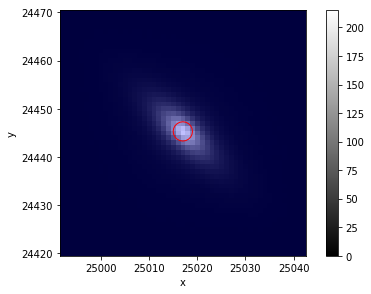

In [51]:
cutout_image = make_cutout_image(butler, ra, dec, datasetType='deepCoadd', dataId=diffId)

Here, `make_cutout_image` is using `lsst.afw.display` to show the image.  So thus, even though the image is a cutout, it knows what the original pixel coordinates were and displays those.

Also note that the orientation is in x, y of the deepCoadd image.  Because the coadds are done based on the tract+patch, x, y line up with RA, Dec.  However, for our science image cutouts that we'll see below, their orientations will each be different.

The above image is in fact gray scale.  It looks blue, because the "footprint" of the galaxy, i.e. all of the pixels associated with the measurement of the galaxy, covers the entire postage stamp region, and by default we are displaying the mask planes. A 'mask' doesn't mean good or bad, it's a plane of information about a particular property.  While many mask bits refer to problems, or potential problems, one of the key mask bits is DETECTED, which defines the footprint of the object. 

We can look up what those mask planes are but creating just a dummy display and asking what the mask plane bits are for our image:

In [52]:
frame = 1
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib', title='coadd')

for maskName, maskBit in cutout_image.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(maskName, display.getMaskPlaneColor(maskName)))

BAD: red
BRIGHT_OBJECT: None
CLIPPED: None
CR: magenta
CROSSTALK: None
DETECTED: blue
DETECTED_NEGATIVE: cyan
EDGE: yellow
INEXACT_PSF: None
INTRP: green
NOT_DEBLENDED: None
NO_DATA: orange
REJECTED: None
SAT: green
SENSOR_EDGE: None
SUSPECT: yellow
UNMASKEDNAN: None


<Figure size 432x288 with 0 Axes>

And you can see that `DETECTED` is blue.

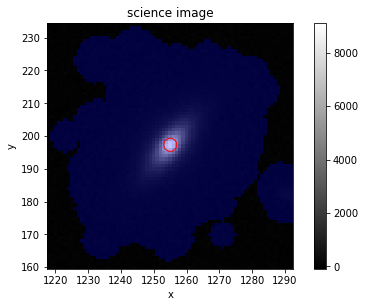

In [53]:
cutout_image = make_cutout_image(butler, ra, dec, datasetType='calexp', dataId=diffId, title='science image')

The footpring above is smaller in the individual image than in the coadd.  That's because the coadd goes much deeper and sees the galaxy outskirts better.  Also note that the mask plane contains the information about which pixels are part of footprints.  This is not explicitly showing the specific footprint of the object we're centered on.

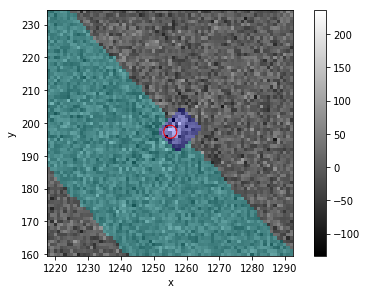

In [54]:
cutout_image = make_cutout_image(butler, ra, dec, datasetType='deepDiff_differenceExp', dataId=diffId)

Note that the pixel coordinates for the subtracted image (`deepDiff_differenceExp`) are the same as those of the science image (`calexp`).

The detected `diaSource` footprint is in blue.

You also might notice a significant green stripe going up and to the left.  This (I believe) are interpolated pixels `INTRP`, where the interpolation contamination has been convolved out to a very large area by the effective size of the convoultion kernel.  The threshold for determining when a pixel is affeted by a given mask plane bit as its grown out like this is configurable.

Somewhat confusingly, `DETECTED_NEGATIVE` is also green.  You'll see some examples of negative detections below in the postage stamps of the difference images.

In [55]:
len(this_diaObject_diaSrc)

291

A given science+difference image pair is oriented the same way, because the coadd is matched to the orientation of the science image.  But because each visit is oriented differently, each postage stamp below will be oriented differently.

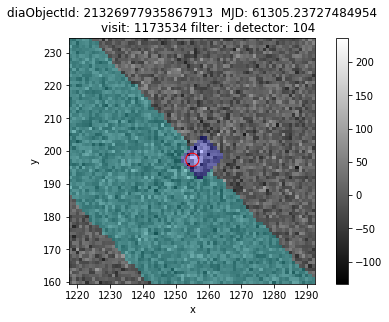

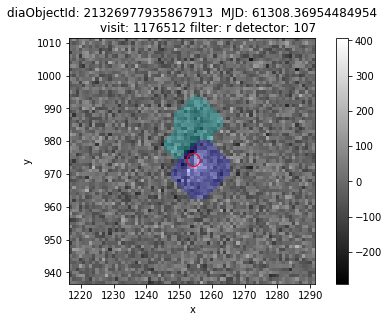

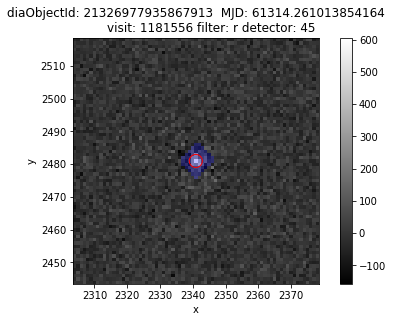

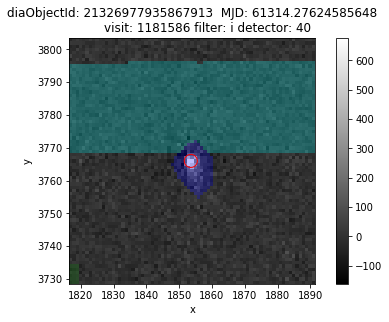

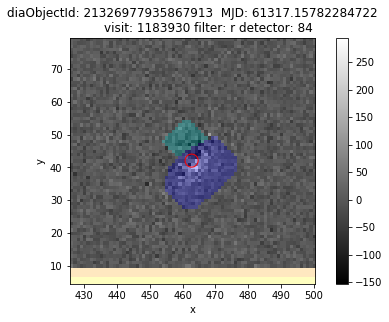

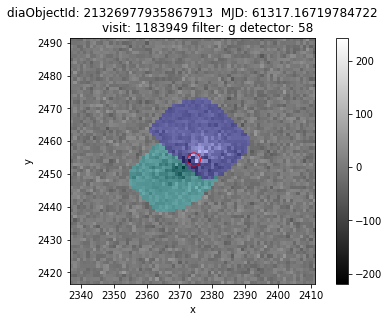

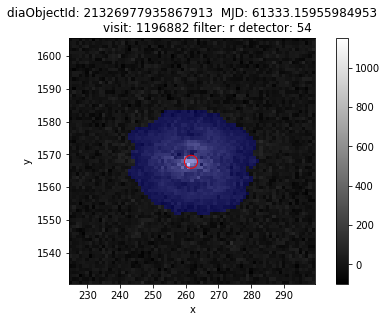

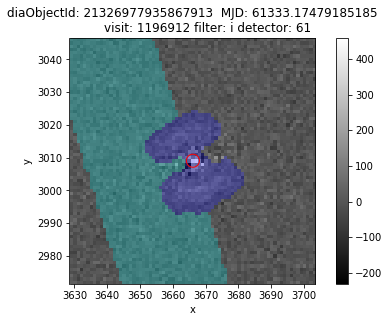

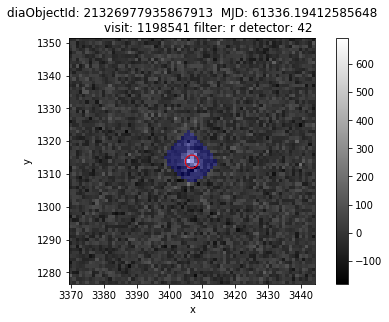

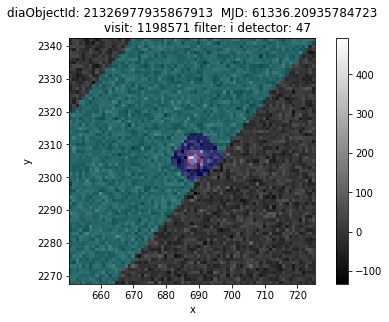

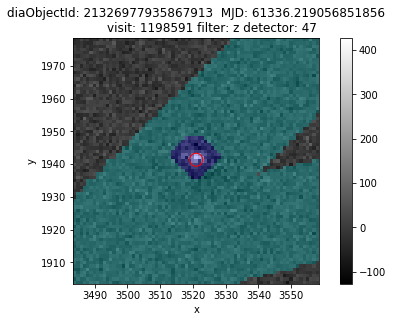

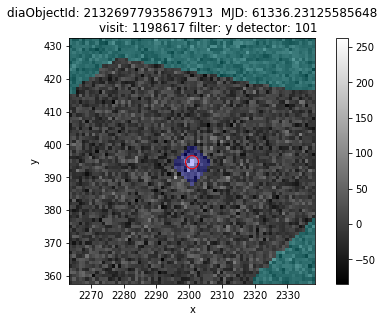

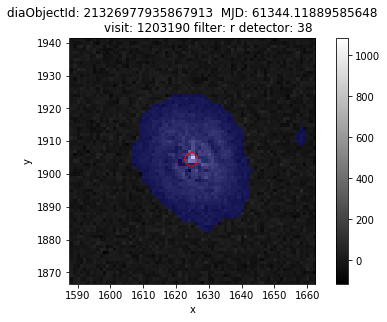

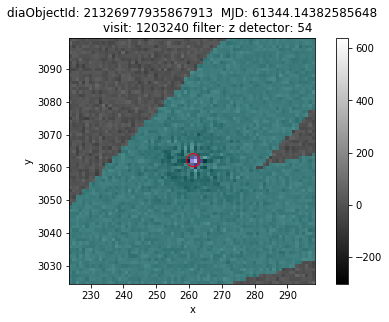

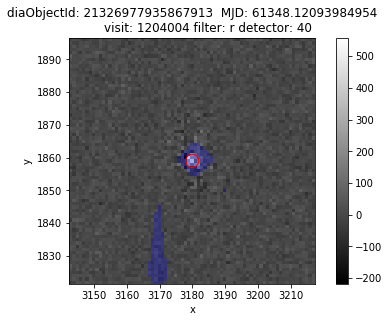

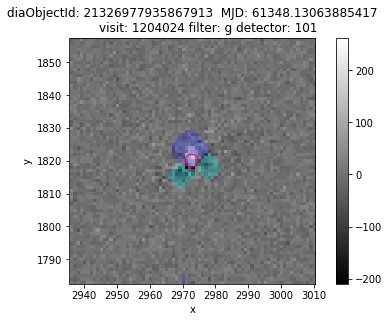

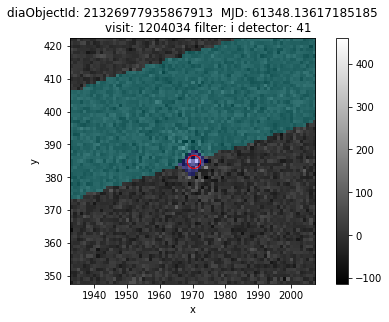

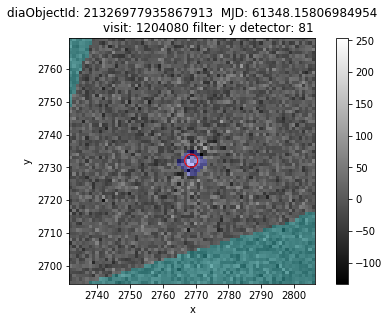

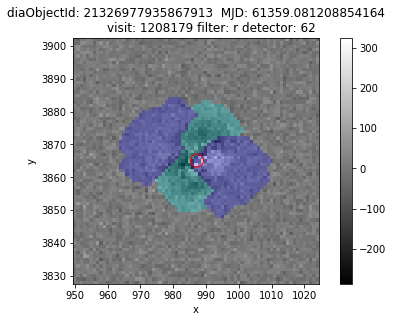

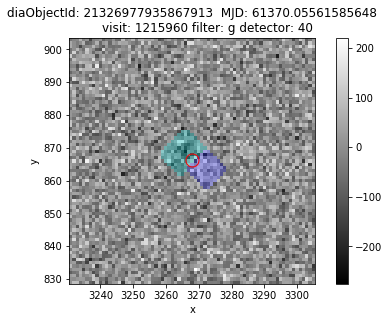

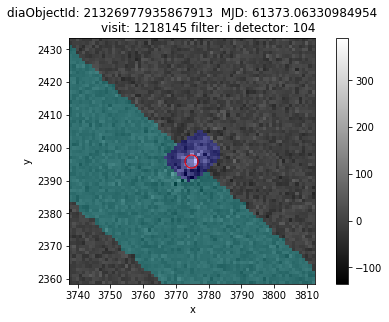

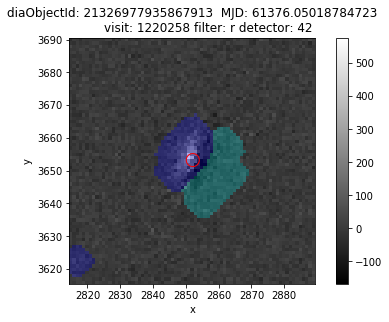

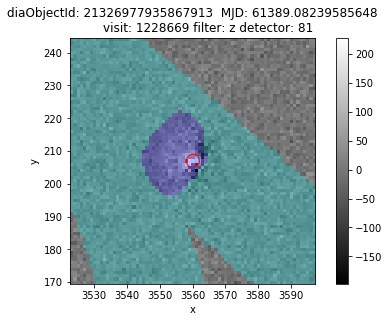

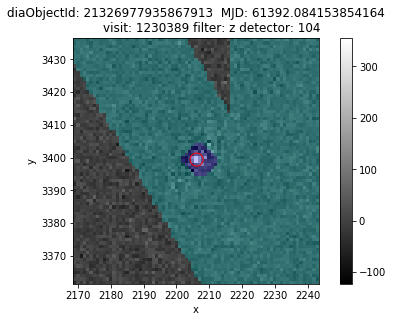

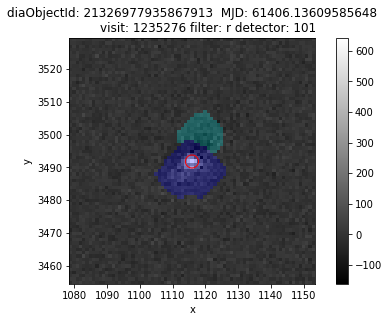

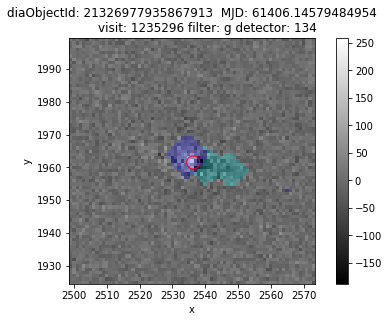

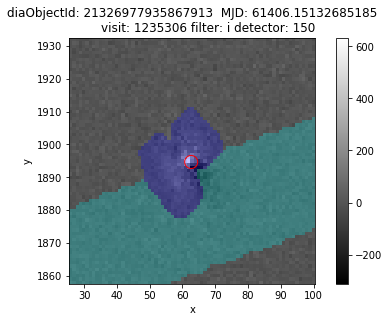

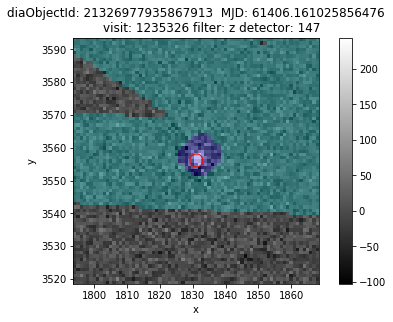

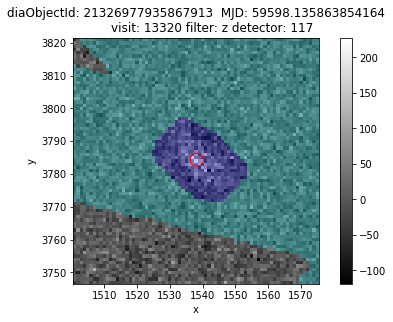

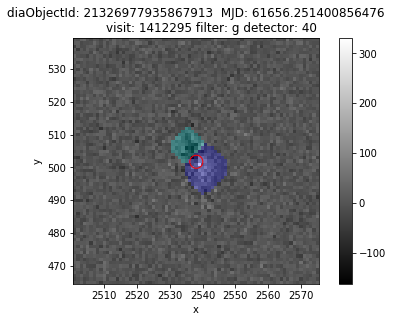

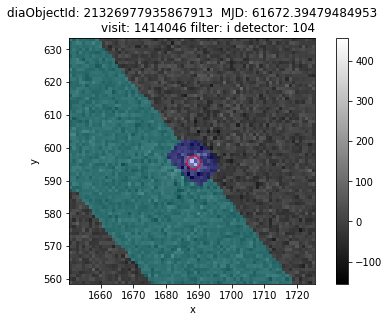

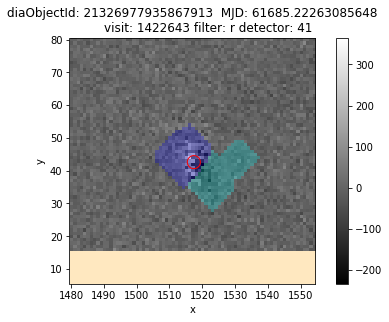

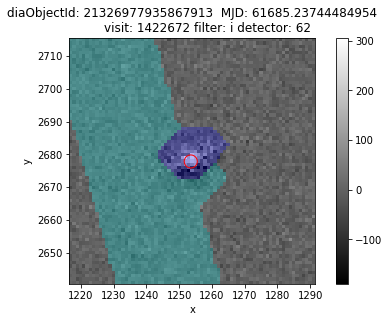

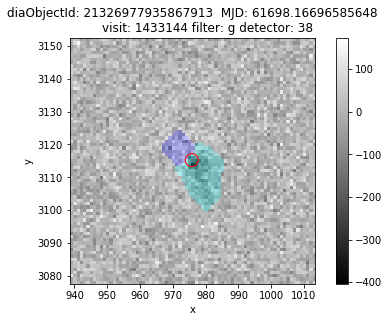

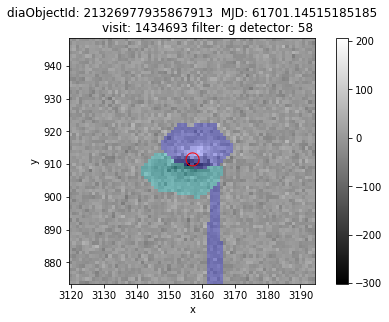

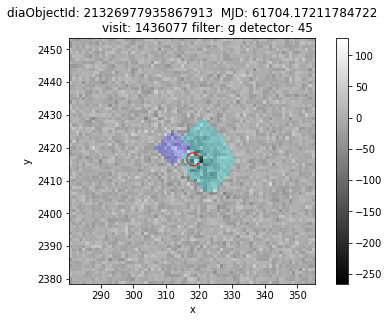

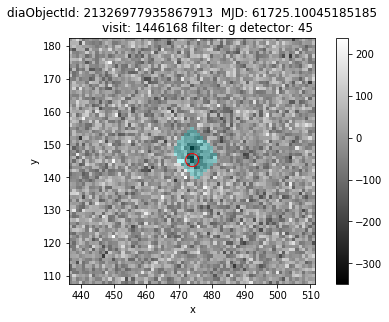

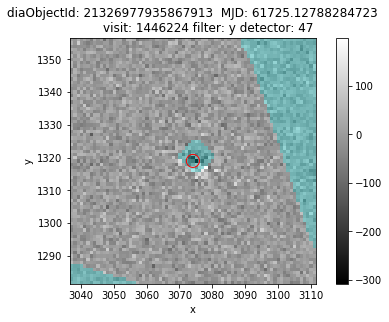

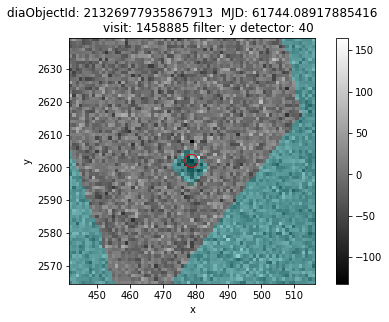

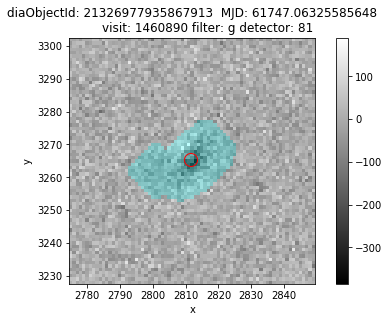

Too near edge of image to get full postage stamp.  Skipping {dataId}


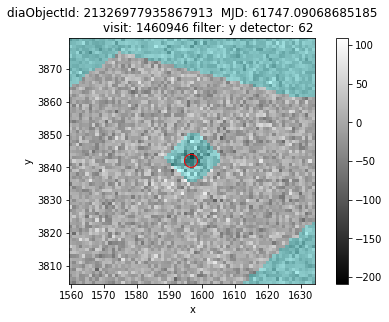

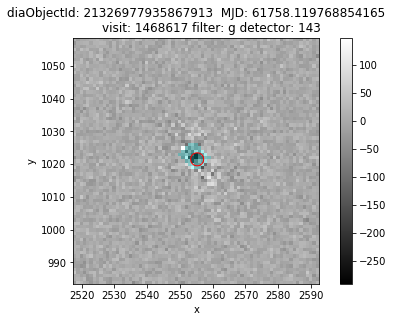

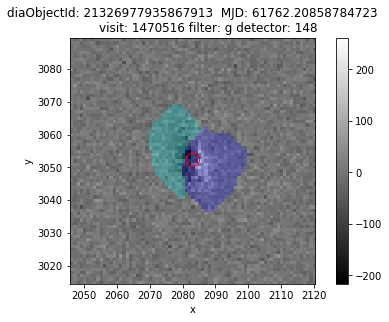

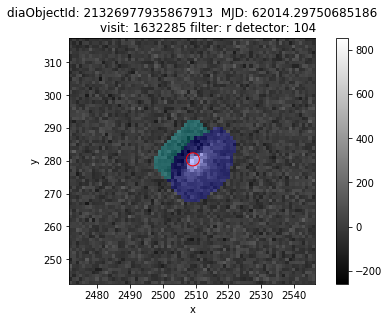

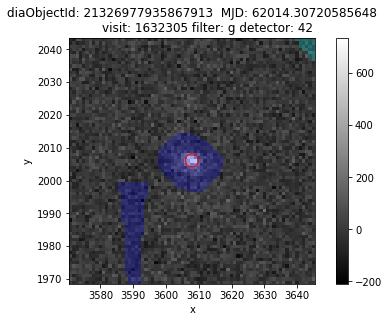

Too near edge of image to get full postage stamp.  Skipping {dataId}


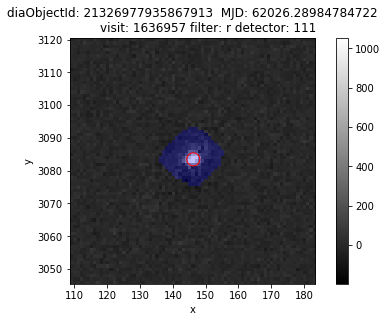

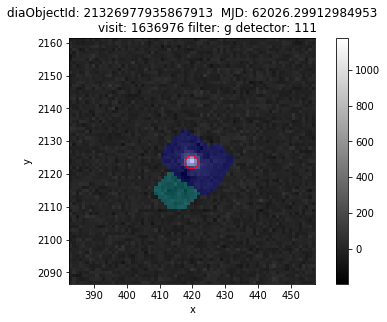

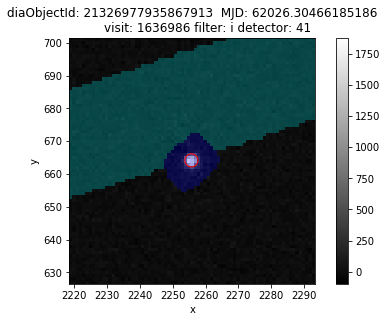

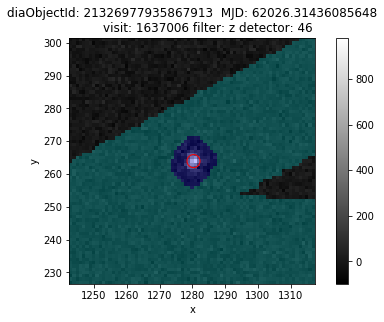

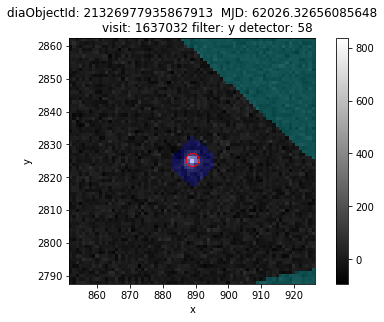

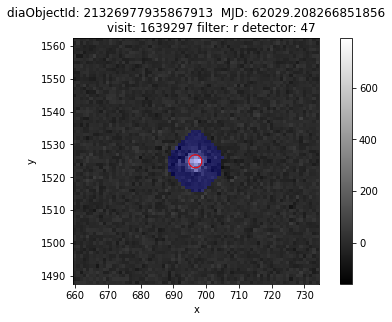

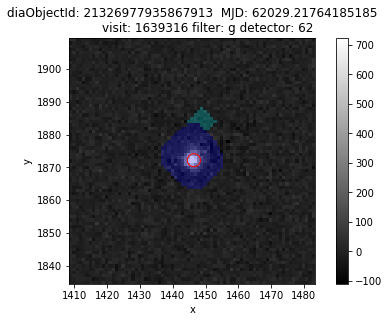

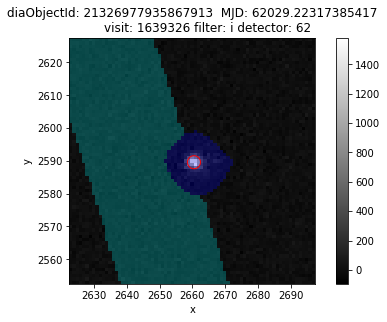

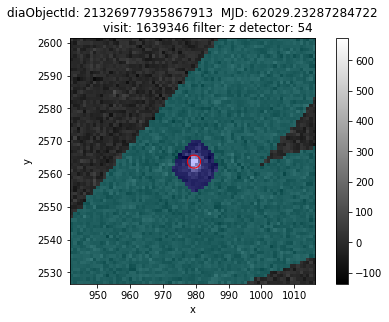

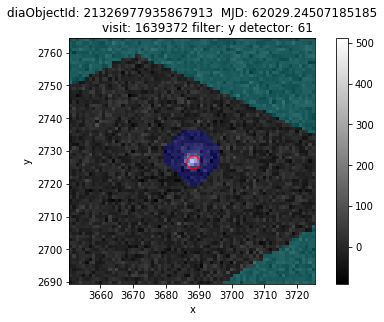

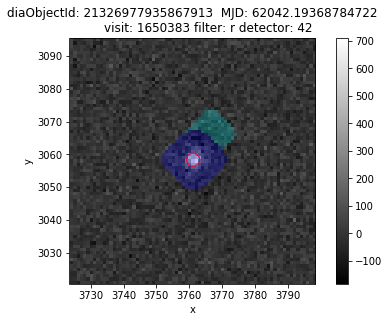

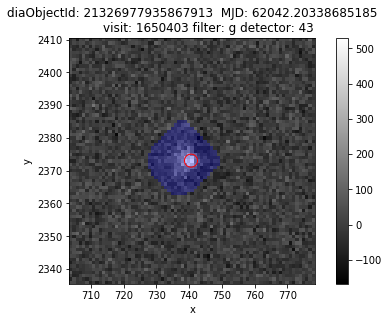

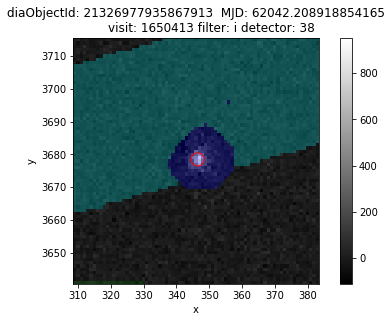

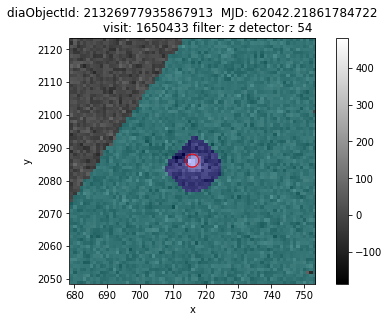

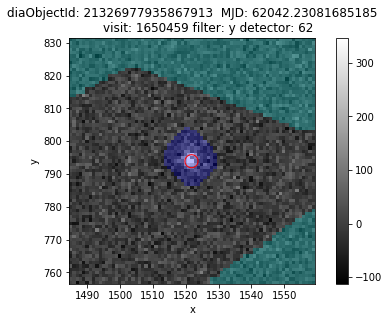

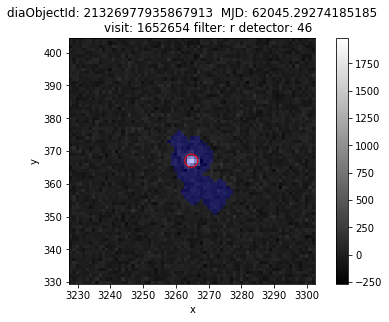

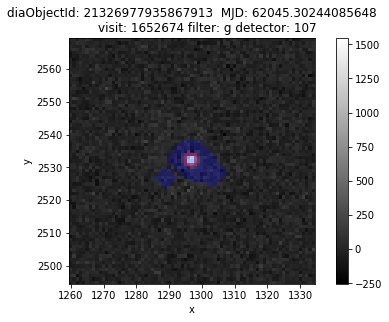

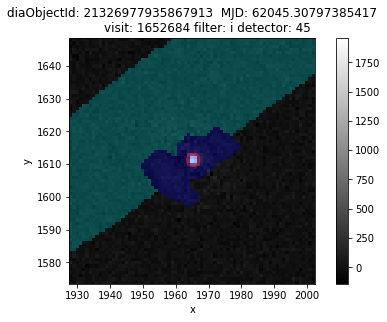

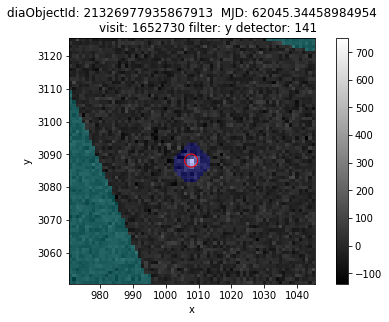

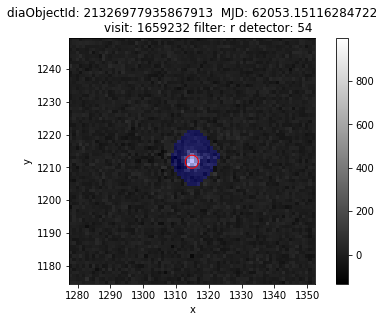

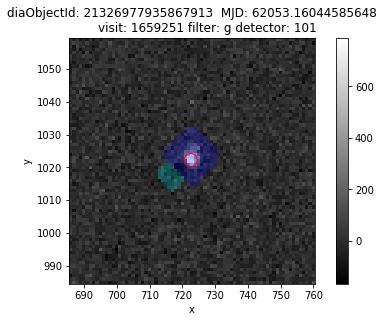

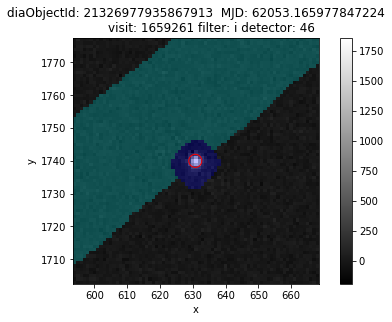

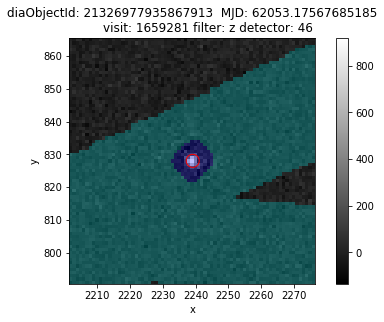

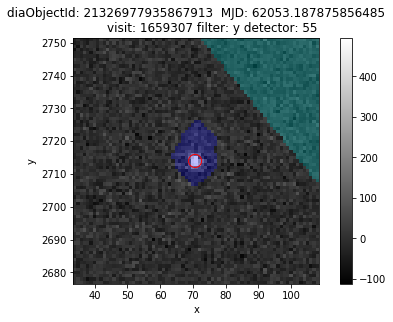

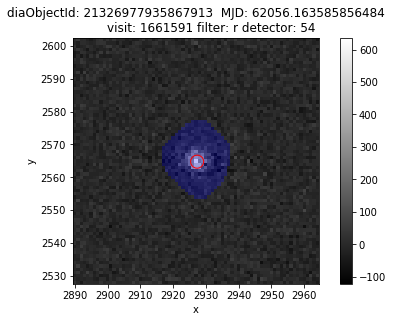

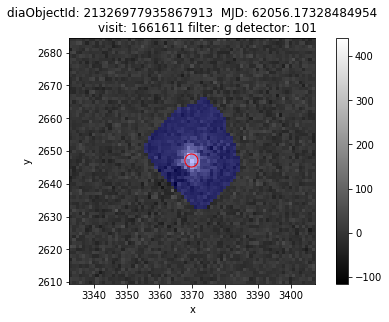

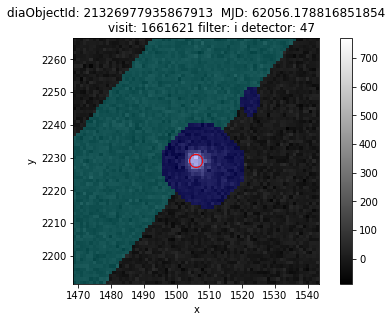

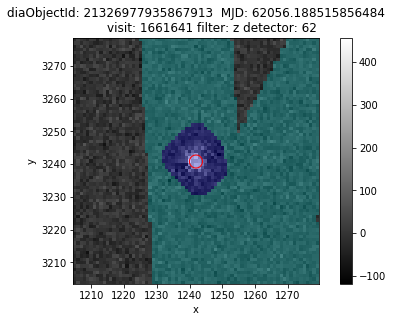

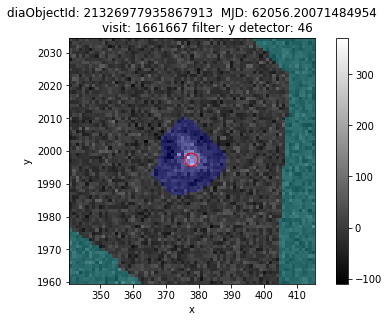

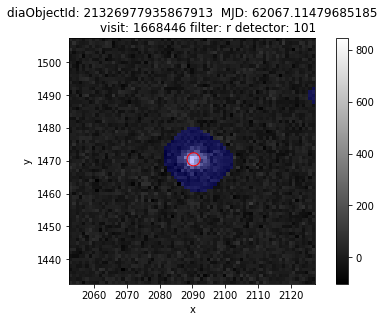

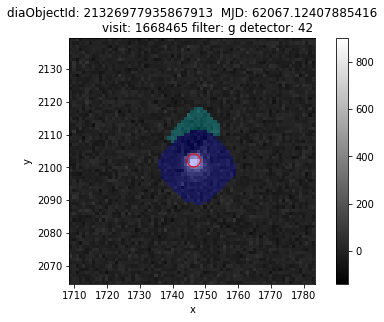

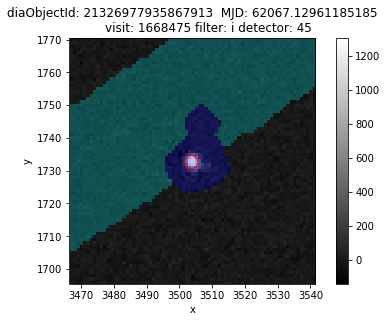

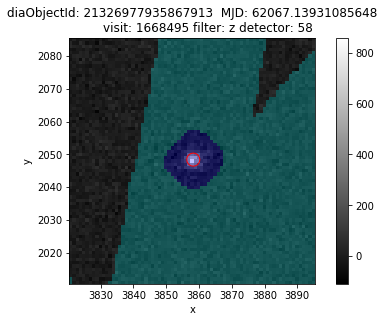

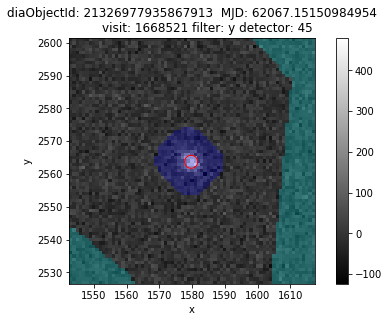

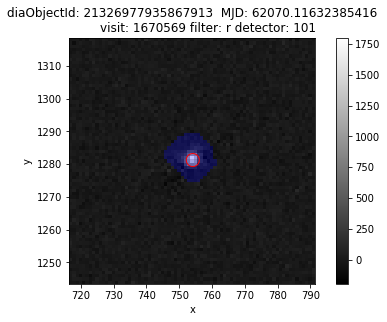

Too near edge of image to get full postage stamp.  Skipping {dataId}


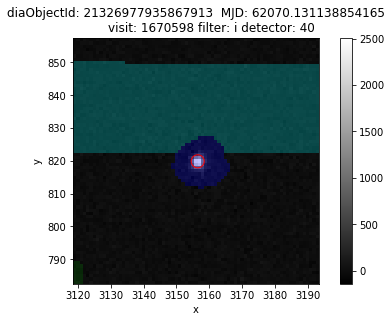

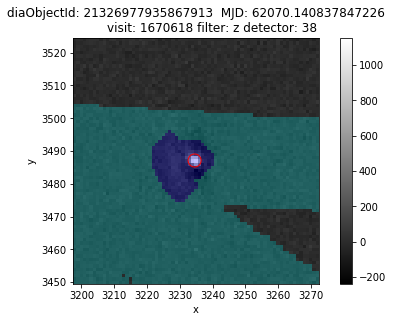

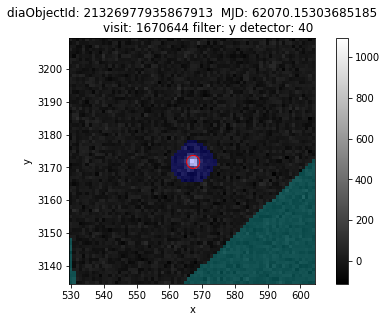

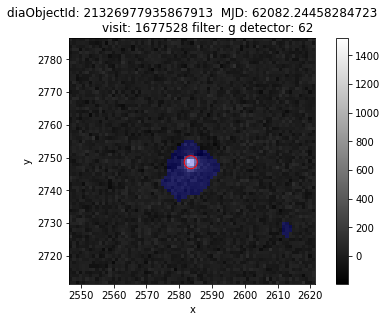

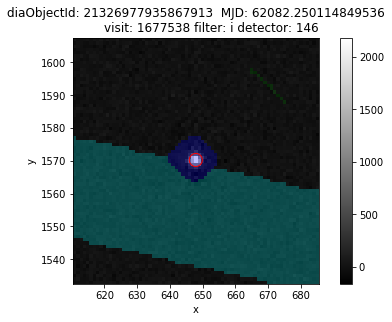

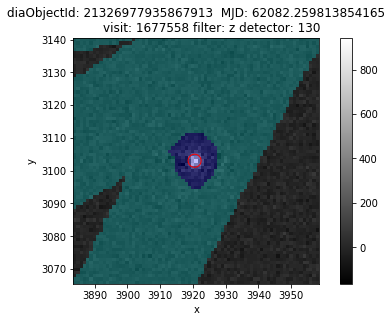

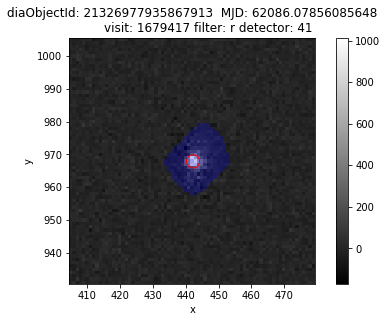

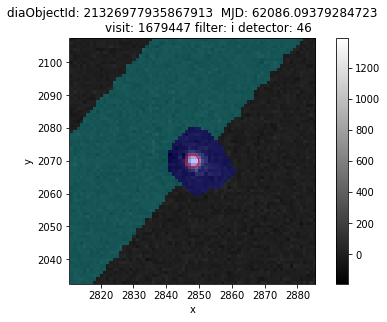

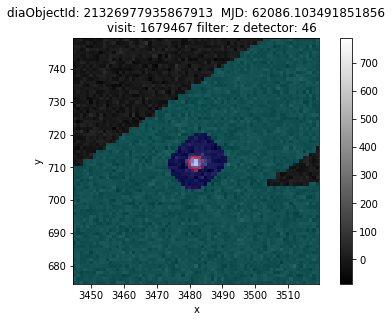

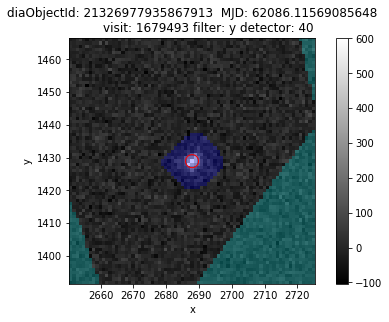

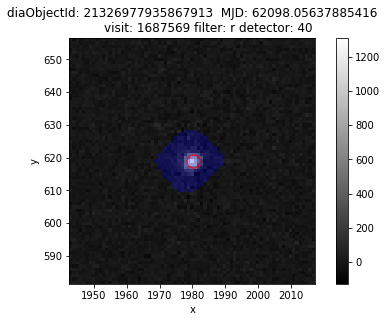

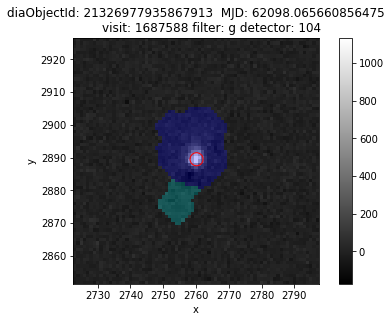

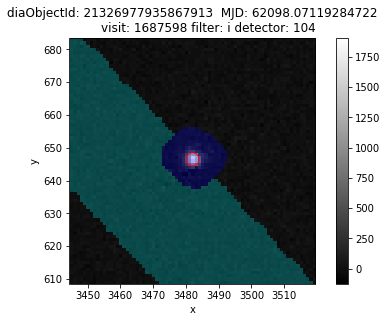

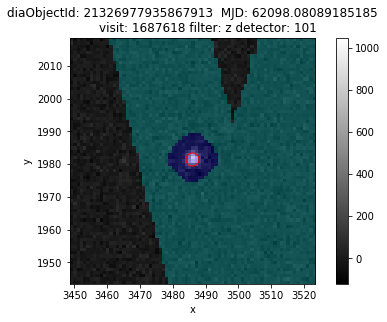

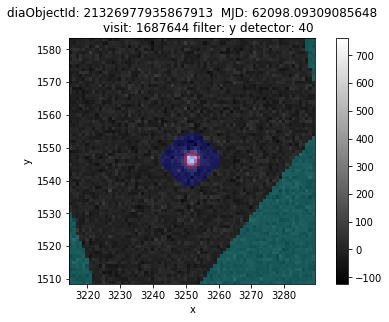

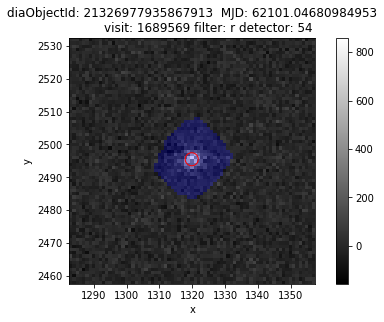

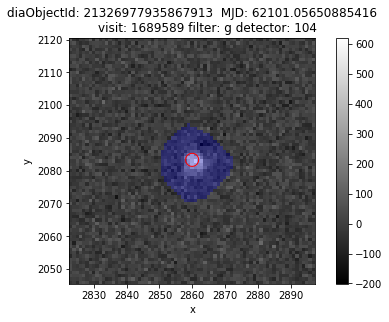

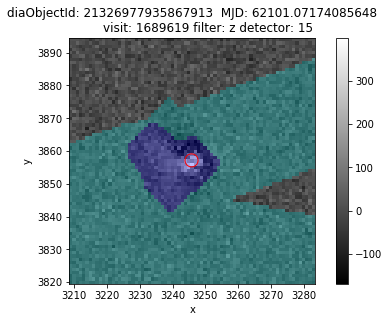

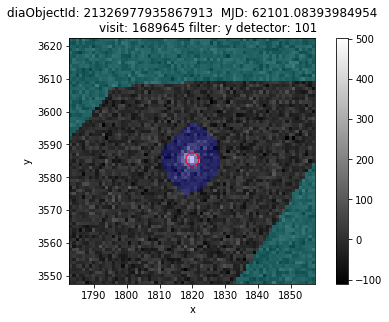

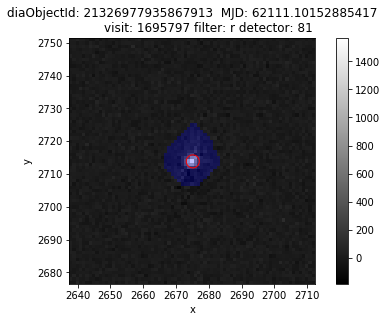

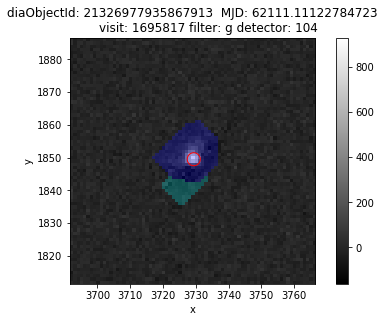

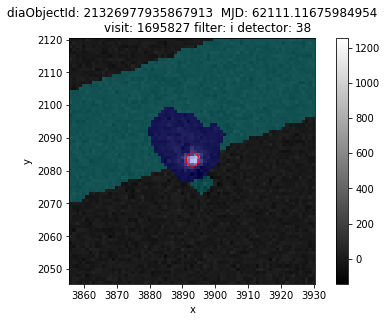

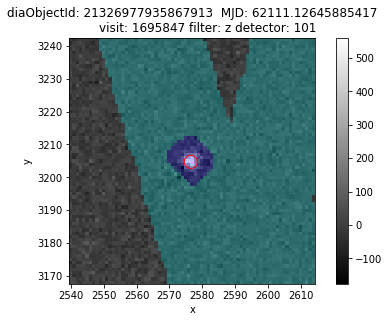

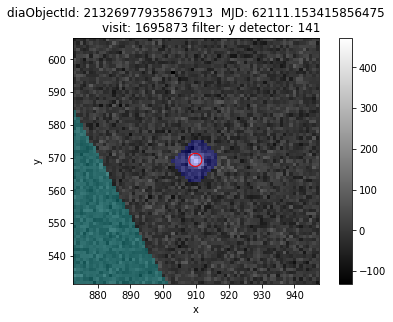

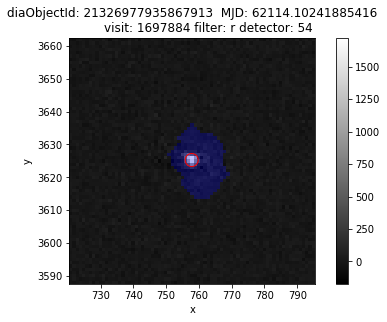

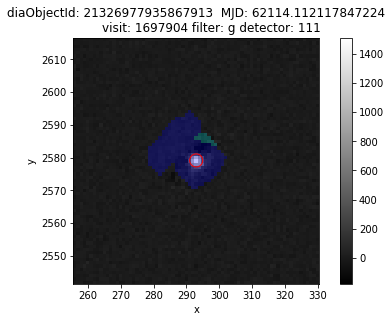

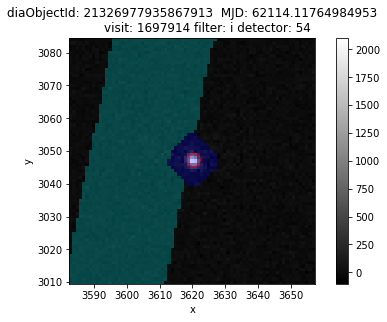

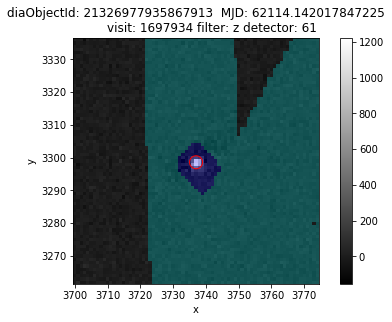

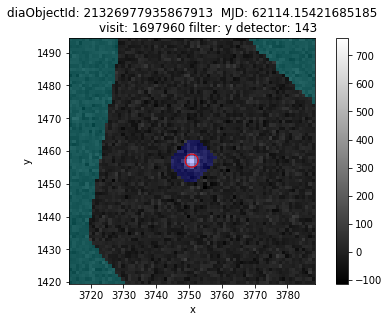

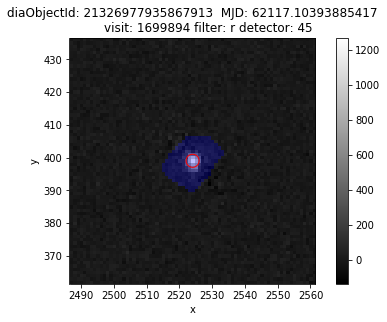

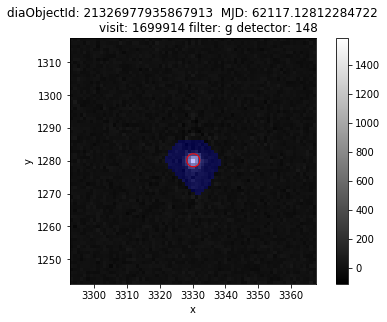

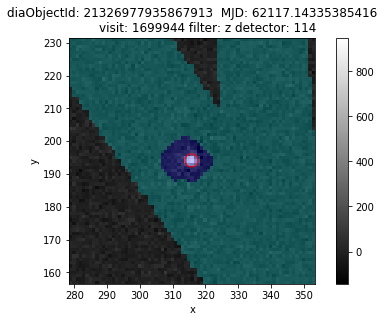

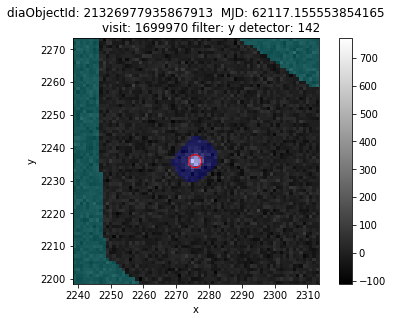

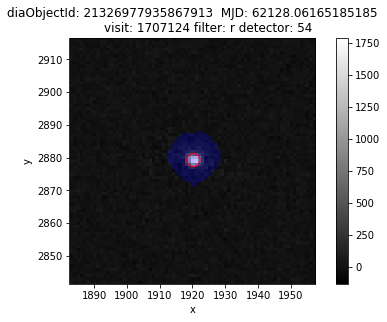

Too near edge of image to get full postage stamp.  Skipping {dataId}


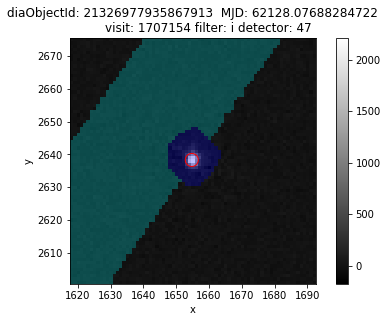

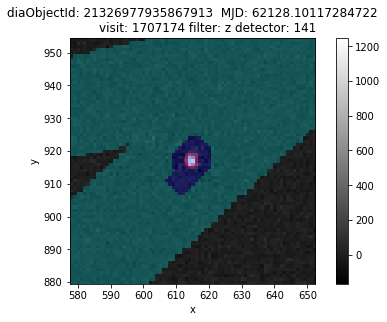

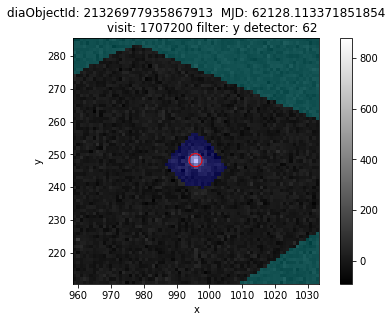

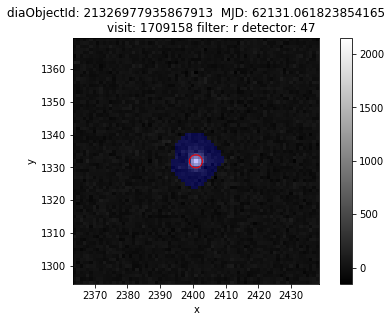

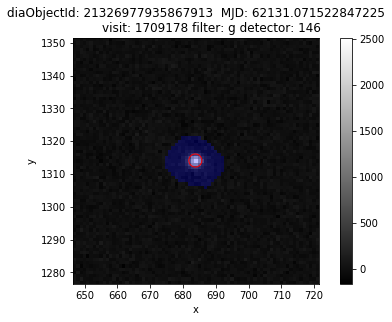

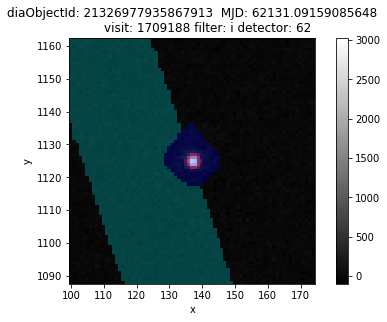

Too near edge of image to get full postage stamp.  Skipping {dataId}


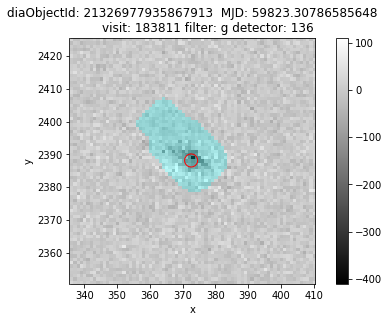

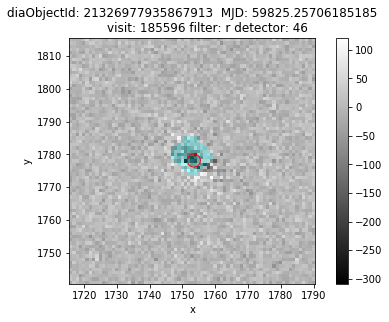

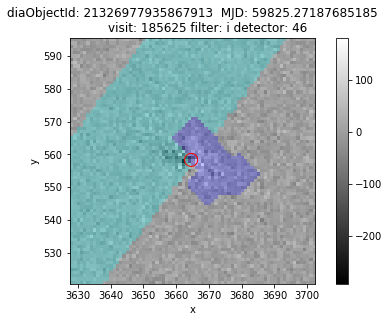

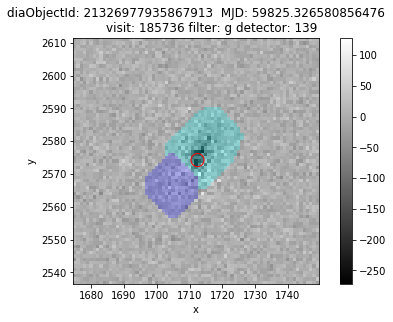

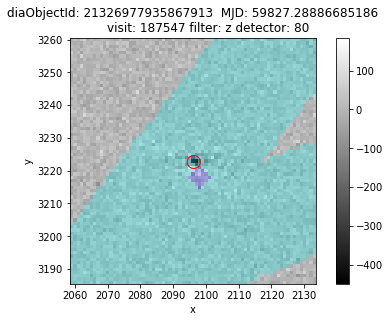

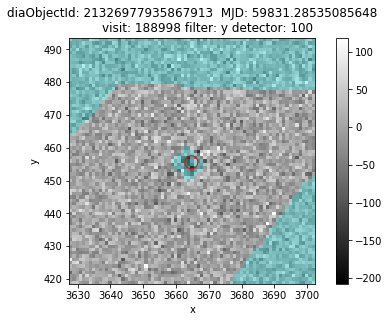

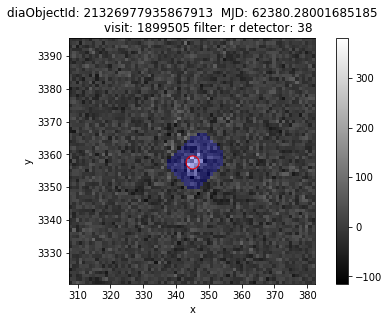

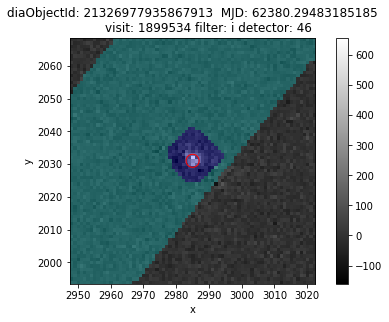

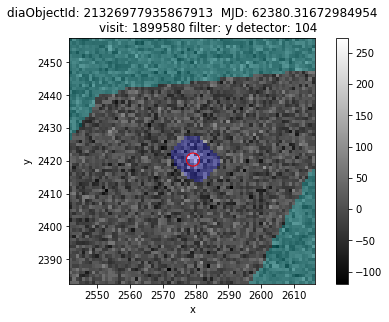

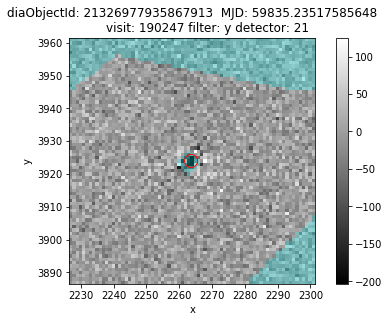

Too near edge of image to get full postage stamp.  Skipping {dataId}


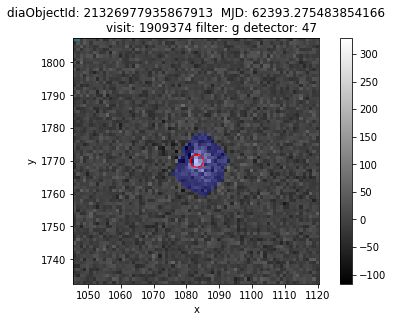

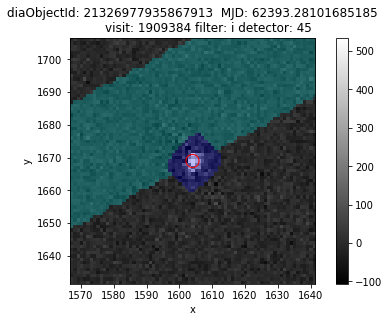

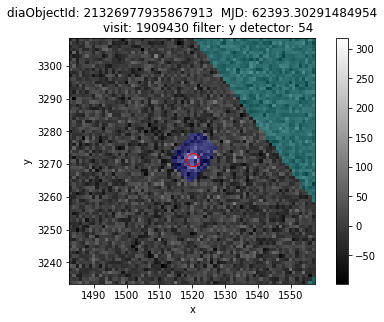

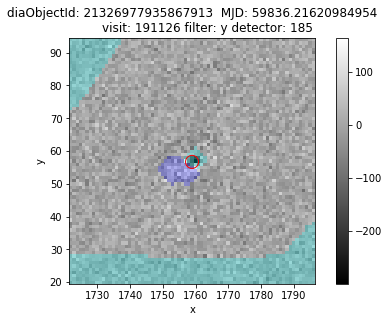

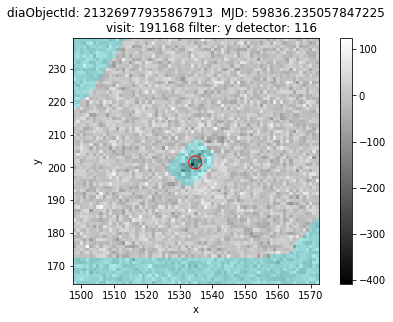

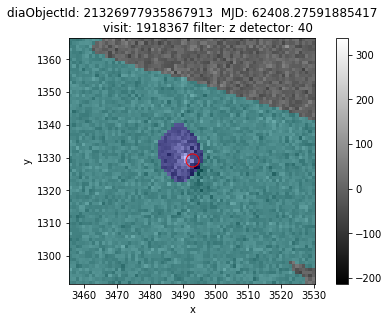

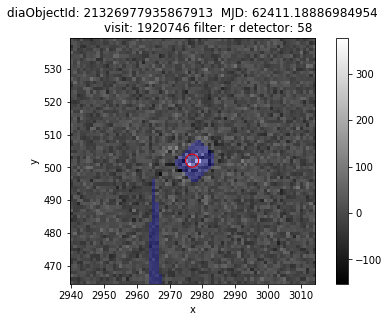

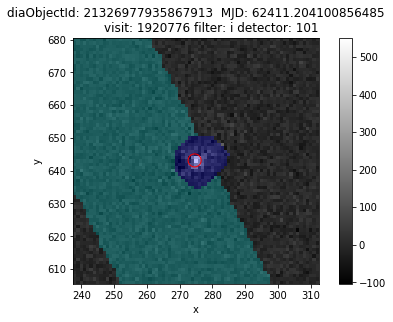

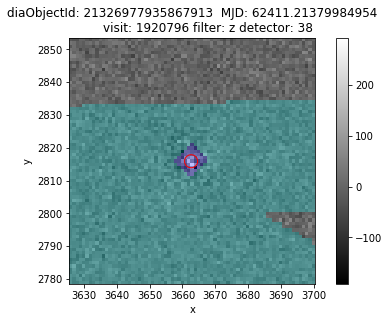

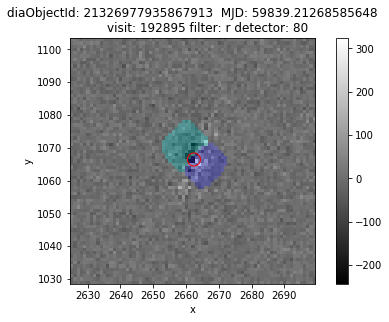

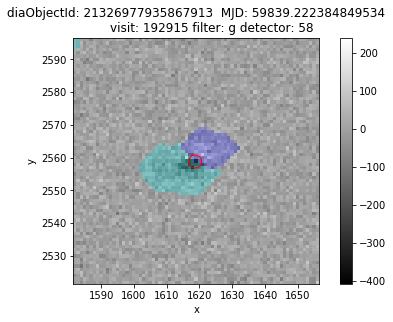

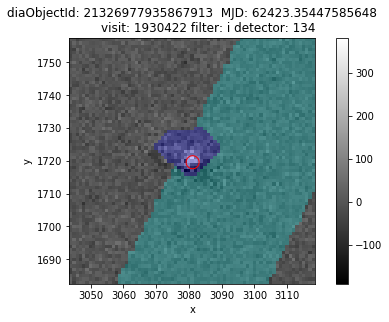

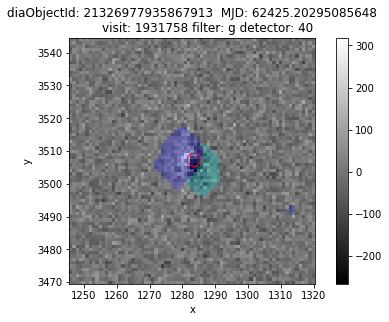

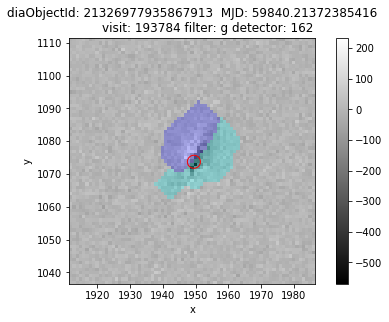

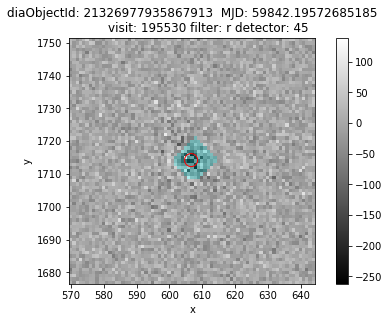

Too near edge of image to get full postage stamp.  Skipping {dataId}


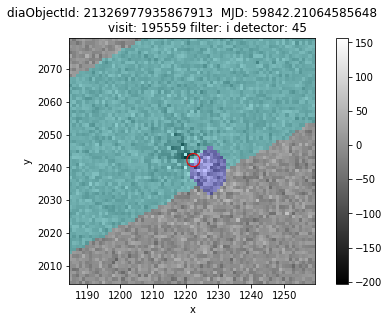

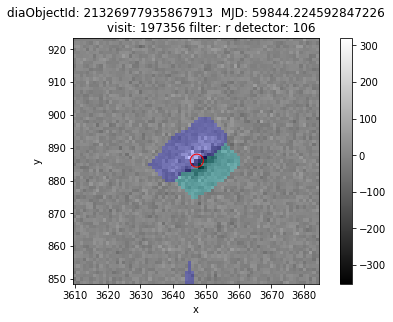

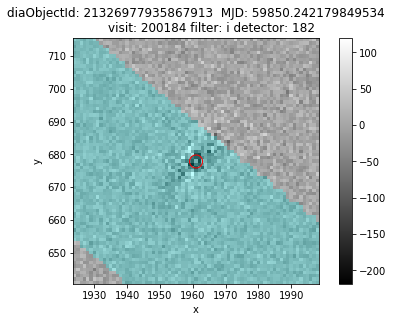

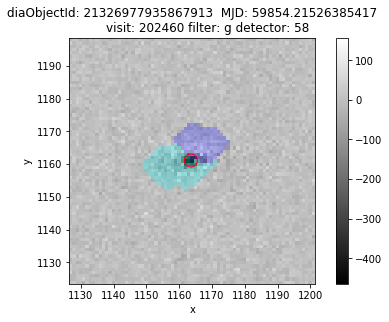

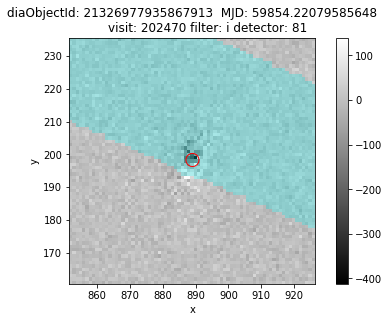

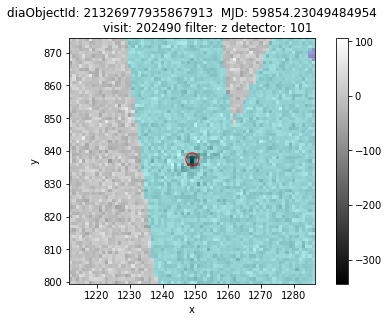

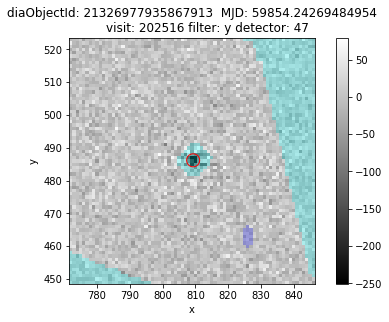

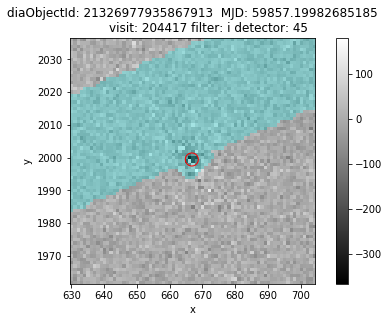

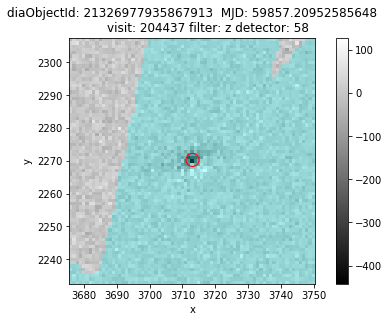

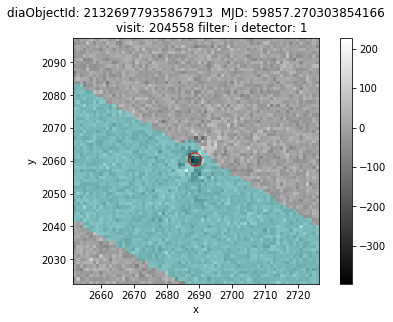

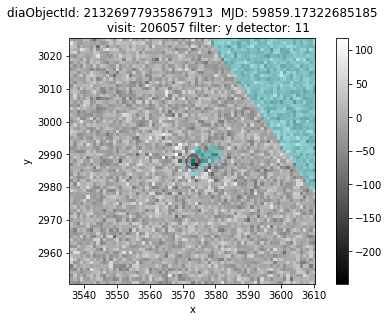

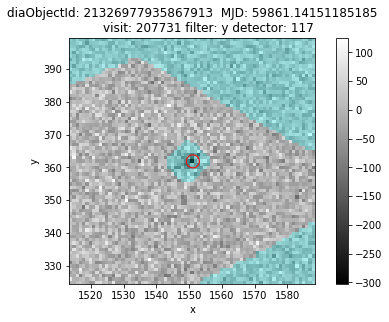

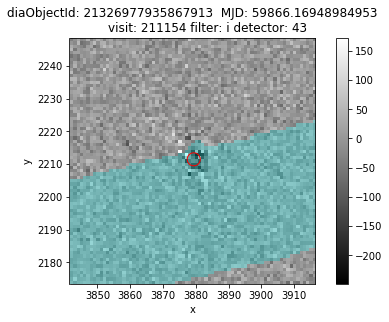

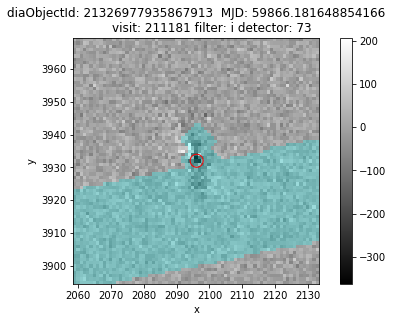

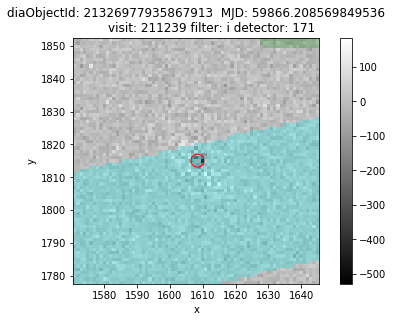

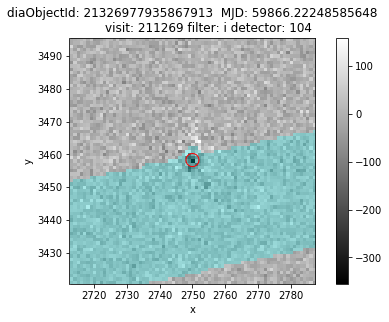

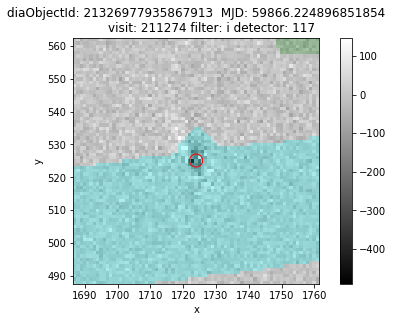

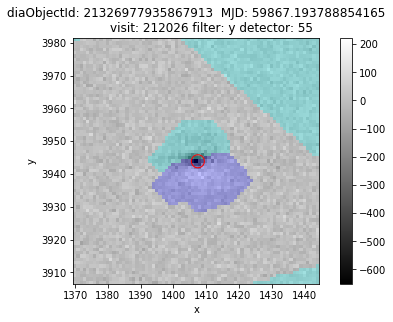

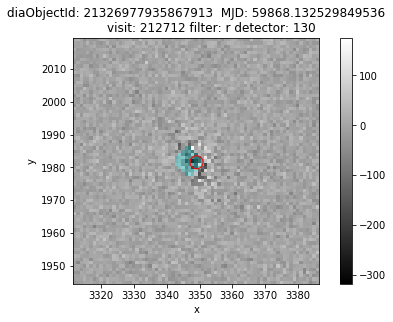

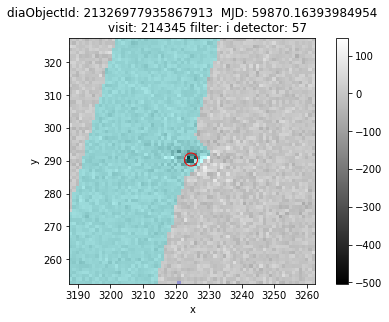

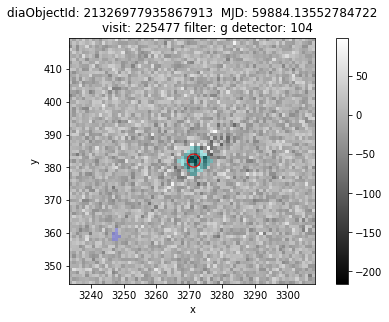

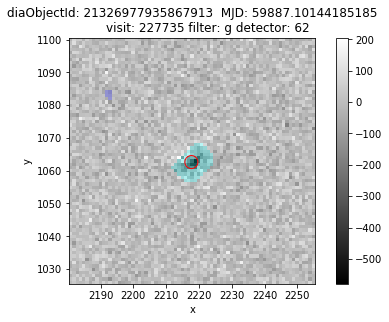

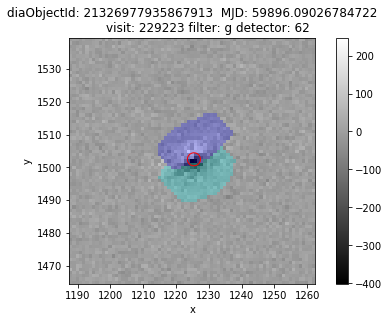

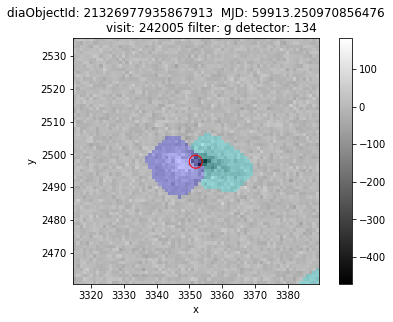

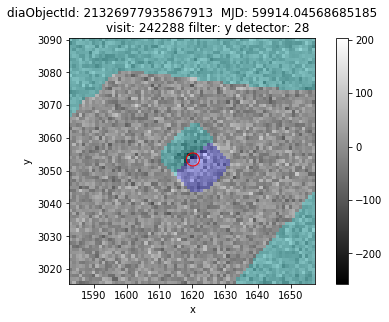

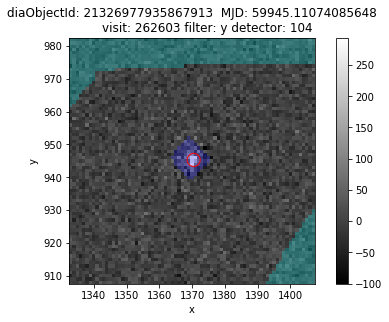

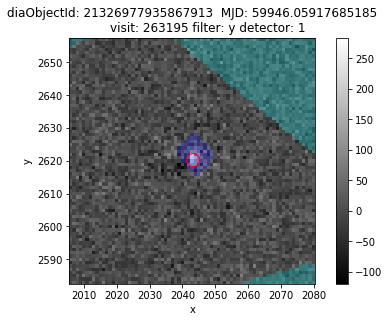

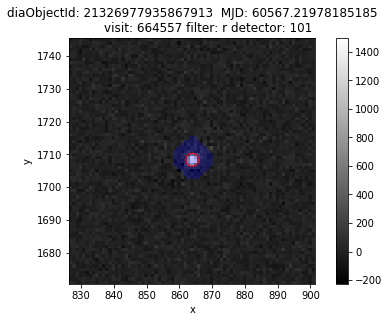

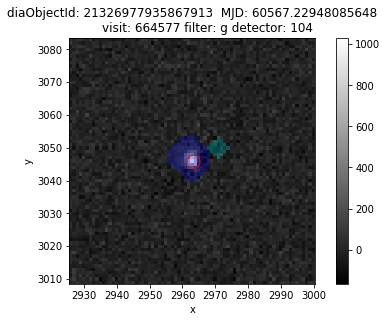

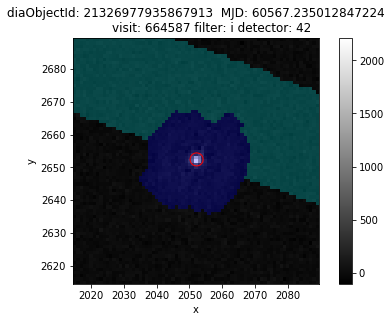

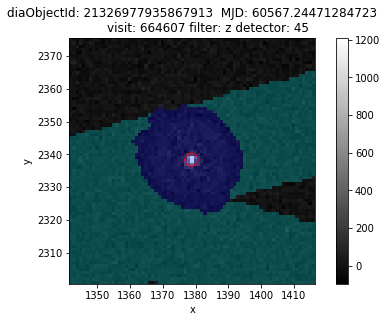

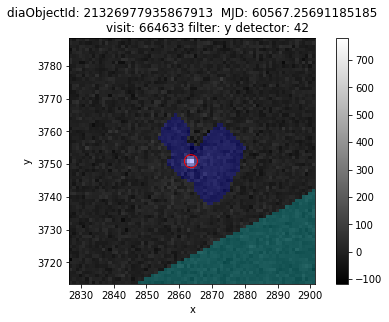

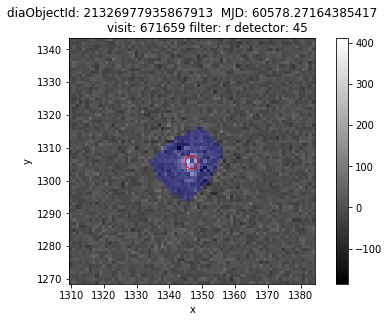

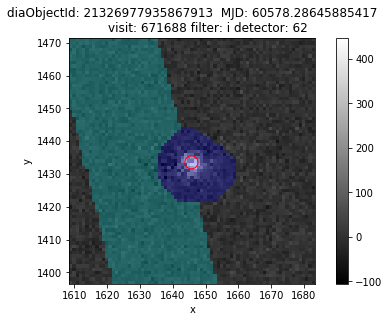

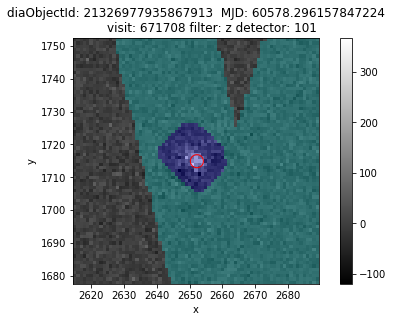

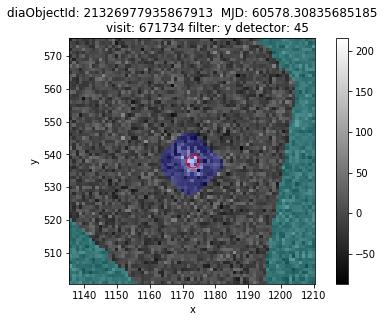

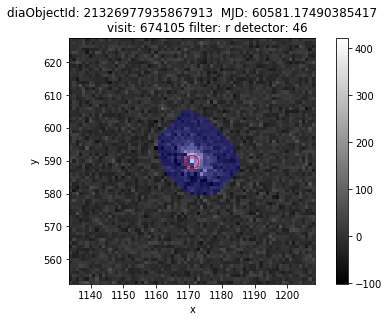

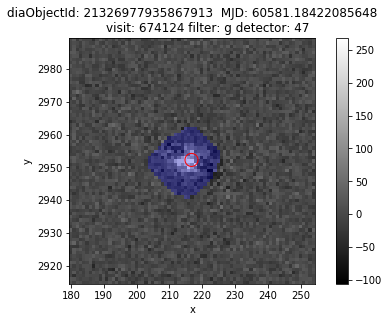

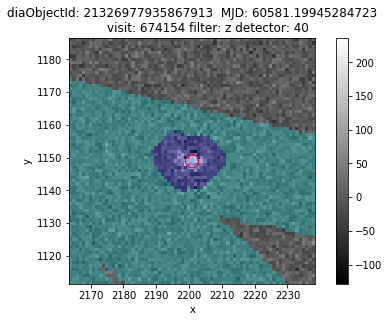

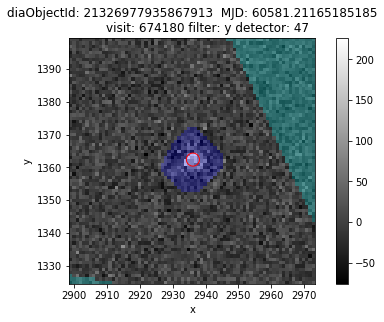

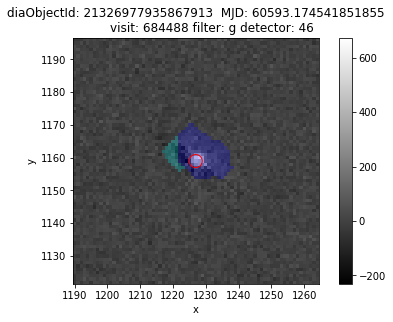

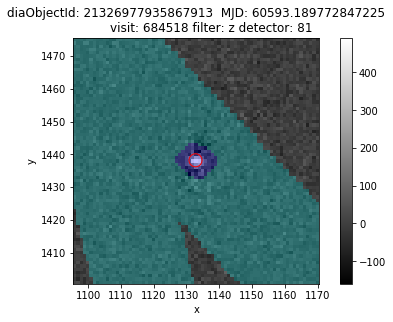

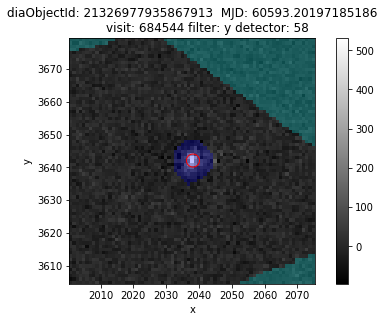

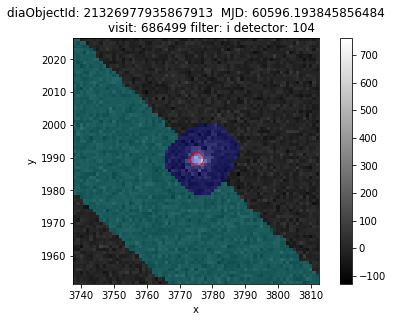

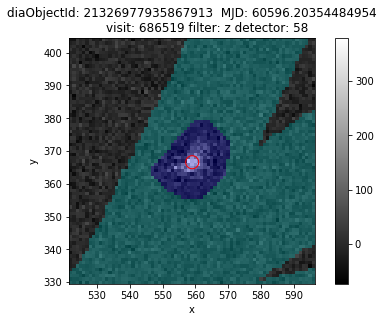

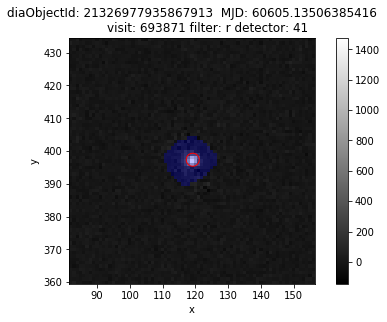

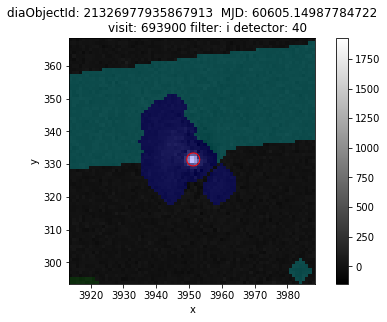

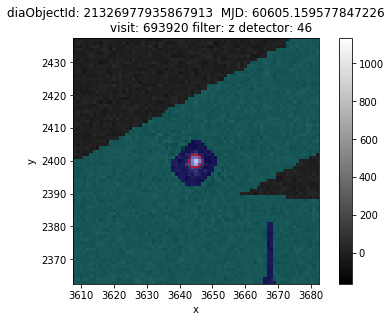

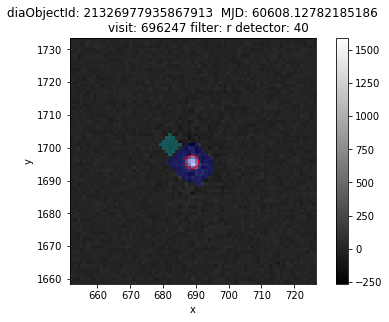

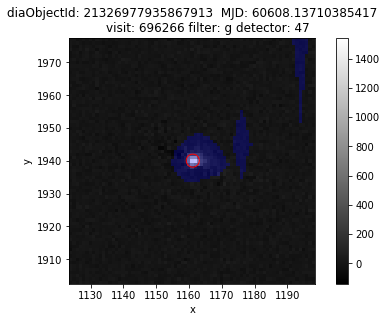

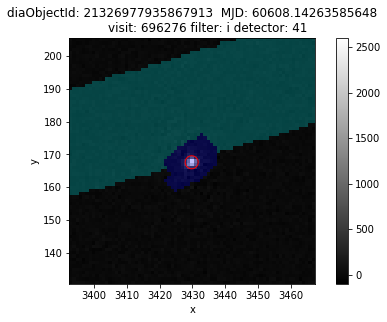

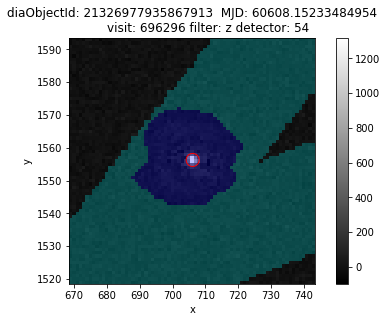

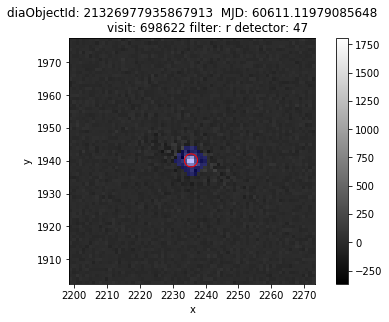

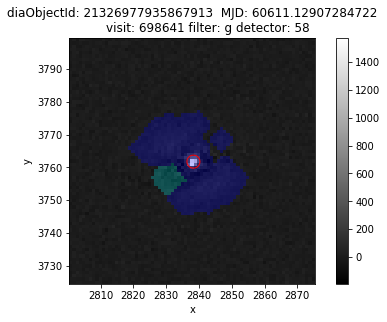

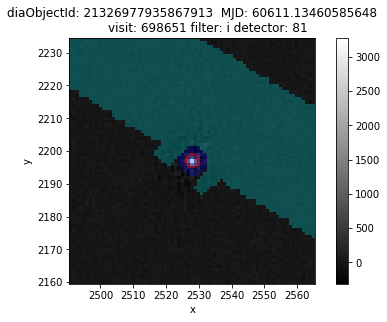

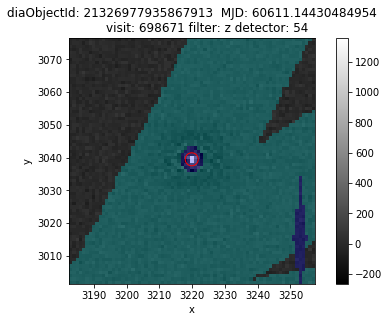

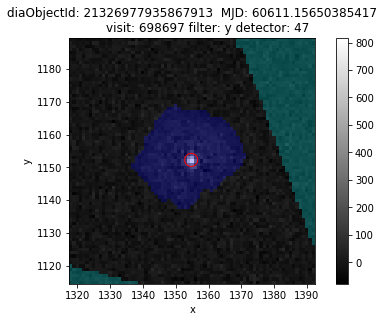

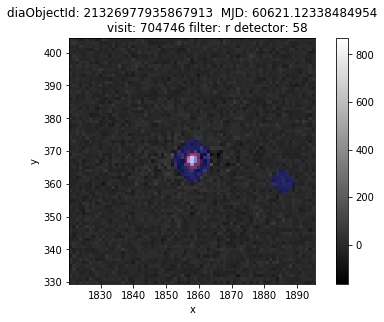

In [ ]:
# Catch attempts to make stamps too near the edge of the image to complete.
# There are diaSources smaller than this.
# Our choice of cutout size is slightly arbitrary and is also much larger than a point source.
# An improvement would be to get the postage stamp to return a full image with the mask plane set appropriately 
# for the missing pixels.
from lsst.pex.exceptions import LengthError

for diff_visit in this_diaObject_diaSrc.itertuples():
    diffId = {}
    # We have to convert from int64 to int to get the formatting to work right in the Gen 2 template string.
    diffId['visit'] = int(diff_visit.visit)
    diffId['filter'] = diff_visit.filter
    diffId['detector'] = int(diff_visit.detector)
    title = f'''diaObjectId: {diff_visit.diaObjectId}  MJD: {diff_visit.mjd}
        visit: {diff_visit.visit} filter: {diff_visit.filter} detector: {diff_visit.detector}'''
    mjd = diff_visit.mjd
    diaObjectId = diff_visit.diaObjectId
    
    try:
        make_cutout_image(butler, ra, dec, datasetType='deepDiff_differenceExp', dataId=diffId, title=title)
    except LengthError:
        print('Too near edge of image to get full postage stamp.  Skipping {dataId}')